In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, List, Tuple, Optional, Any, Callable
import math
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

In [17]:
# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TIMESTEPS = 1000 
BATCH_SIZE = 50
LEARNING_RATE = 1e-3
EPOCHS = 300
DATASET_SIZE = 10000

# Tree Data Specific Configuration
TREE_FEATURE_DIM = 2
TREE_NUM_LAYERS = 7
TREE_TOTAL_NODES = 2**TREE_NUM_LAYERS - 1
TREE_ALPHA = 0.7
TREE_NOISE_STD = 0.01

####
TREE_NUM_LAYERS_CONFIG = 7
SWISS_ROLL_SEQ_NUM_TREE_LAYERS_CONFIG = 3
TREE_FEATURE_DIM_CONFIG = 2
SWISS_ROLL_SEQ_FEATURE_DIM_CONFIG = 1

CURRENT_FEATURE_DIM = -1 # Placeholder, I set it in main execution
CURRENT_NUM_LAYERS = -1  # Placeholder, I set it in main execution

# Swiss Roll Data Specific Configuration, I tried this as a first synthetic dataset(for Sequential Model)
SWISS_ROLL_SEQ_FEATURE_DIM = 1 # Each coordinate X_i is a scalar feature
SWISS_ROLL_SEQ_NUM_TREE_LAYERS = 3 # X1, X2, X3 as layers 0, 1, 2
# For Baseline model on Swiss Roll (flattened sequential data)
SWISS_ROLL_BASELINE_TOTAL_NODES = SWISS_ROLL_SEQ_NUM_TREE_LAYERS # 3 nodes (X1, X2, X3) in sequence
SWISS_ROLL_BASELINE_FEATURE_DIM = SWISS_ROLL_SEQ_FEATURE_DIM # 1 feature per node

# --- Experiment Type Selector ---
EXPERIMENT_TYPE = 'tree' # Options: 'tree', 'swiss_roll'

In [3]:
# --- Helper Functions (Beta Schedule, Extract) ---

def linear_beta_schedule(timesteps: int, beta_start: float = 0.0001, beta_end: float = 0.02) -> torch.Tensor:
    """Generates a linear variance schedule."""
    return torch.linspace(beta_start, beta_end, timesteps)

def extract(a: torch.Tensor, t: torch.Tensor, x_shape: Tuple) -> torch.Tensor:
    """
    Extracts coefficients for specific timesteps t, reshaping to broadcast.
    Ensures tensors are on the same device for gather.
    """
    batch_size = t.shape[0]
    out = a.gather(-1, t.long())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

## Autoregressive Tree Data Generation

In [4]:
# --- Autoregressive Tree Data Generation and Handling ---

def generate_autoregressive_tree(num_layers: int, alpha: float, noise_std: float, feature_dim: int) -> Dict[int, np.ndarray]:
    """
    Generates a single binary tree where node value = alpha * parent_value + noise.
    Returns a dictionary {layer_idx: layer_node_values_array}.
    """
    tree = {}
    tree[0] = np.random.randn(1, feature_dim).astype(np.float32) + 1 # Root

    for k in range(1, num_layers):
        parent_layer_values = tree[k-1]
        num_parents = parent_layer_values.shape[0]
        num_children = num_parents * 2
        current_layer_values = np.zeros((num_children, feature_dim), dtype=np.float32)
        for i in range(num_parents):
            parent_value = parent_layer_values[i]
            current_layer_values[2*i] = alpha * parent_value + np.random.randn(feature_dim) * noise_std
            current_layer_values[2*i + 1] = alpha * parent_value + np.random.randn(feature_dim) * noise_std
        tree[k] = current_layer_values
    return tree

# --- Autoregressive rotated tree generation:
def _rotation_matrix(theta: float) -> np.ndarray:
    """2 × 2 counter-clockwise rotation matrix."""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s],[s,  c]], dtype=np.float32)

def generate_rotated_tree(
    num_layers: int,
    noise_std: float,
    *,
    rotation_scheme: str = "spiral",   # {"doubling", "random", "spiral"}
    delta: float = 0.03,                  # translation magnitude ‖t‖
    feature_dim: int = 2,
    seed: int | None = None
) -> Dict[int, np.ndarray]:
    """
    Generate a binary tree of 2-D vectors.

    Each child is drawn from  N(R_θ x_parent + t,  noise_std² I),
    where  R_θ  is a rotation chosen by `rotation_scheme`
    and  t  is a fixed ±delta push along the global x–axis.

    Returns
    -------
    tree : dict[int, np.ndarray]
        Keys are layer indices 0..num_layers-1.
        Values are float32 arrays with shape (2**k, 2).
    """
    if feature_dim != 2:
        raise ValueError("`feature_dim` must be 2 for this distribution.")

    rng = np.random.default_rng(seed)

    # --- root --------------------------------------------------------------
    tree: Dict[int, np.ndarray] = {}
    tree[0] = rng.normal(0.0, 0.05, size=(1, 2)).astype(np.float32)   # tight isotropic Gaussian

    # --- breadth-first generation -----------------------------------------
    for depth in range(1, num_layers):
        parent_values = tree[depth - 1]                # (n_parents, 2)
        n_parents     = parent_values.shape[0]
        children      = np.empty((n_parents * 2, 2), np.float32)

        for i, x_parent in enumerate(parent_values):
            for bit in (0, 1):                         # left=0, right=1
                # 1) pick rotation angle ---------------------------------
                if rotation_scheme == "doubling":
                    # node index within its layer: i ∈ [0, 2**(depth-1)-1]
                    theta = ((2 * i + bit) * np.pi) / (2 ** (depth - 1))
                elif rotation_scheme == "random":
                    theta = rng.uniform(0.0, 2 * np.pi)
                elif rotation_scheme == "spiral":
                    alpha = 5 * np.pi / 180            # 5°
                    theta = (+alpha if bit == 0 else -alpha) * (2 ** (depth - 1))
                else:
                    raise ValueError(f"Unknown rotation_scheme: {rotation_scheme!r}")

                R = _rotation_matrix(theta)

                # 2) translation vector t ----------------------------------
                t = np.array([+delta if bit == 0 else -delta, 0.0], dtype=np.float32)

                # 3) child mean & sample -----------------------------------
                mean = R @ x_parent + t                # apply rotation then translate
                child = mean + rng.normal(0.0, noise_std, size=2)
                children[2 * i + bit] = child

        tree[depth] = children

    return tree


class TreeDataset(Dataset):
    """PyTorch Dataset for generated trees."""
    def __init__(self, num_samples: int, num_layers: int, alpha: float, noise_std: float, feature_dim: int):
        self.num_samples = num_samples
        self.num_layers = num_layers
        self.alpha = alpha
        self.noise_std = noise_std
        self.feature_dim = feature_dim
        print(f"Generating {num_samples} trees...")
        #self.data = [generate_autoregressive_tree(num_layers, alpha, noise_std, feature_dim) for _ in tqdm.trange(num_samples)]
        # generate rotated_tree
        self.data = [generate_rotated_tree(num_layers, noise_std, feature_dim=feature_dim) for _ in tqdm.trange(num_samples)]
        print("Tree Dataset generation complete.")

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> Dict[int, np.ndarray]:
        return self.data[idx]

## Thin Swiss-Roll Data Generation

In [5]:
# --- Swiss Roll - Imports and Parameters ---
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

# Default parameters for Swiss Roll model
DEFAULT_A = 5.0       # initial radius
DEFAULT_B = 10.0      # rate of radius increase (expansion of the roll)
DEFAULT_C = 10.0      # height scaling factor
DEFAULT_K = 3.0       # number of turns (tightness of the spiral)
DEFAULT_SIGMA = 0.1   # noise standard deviation

## Data Flattening/Unflattening and Collation

In [10]:
# --- Data Flattening/Unflattening for Baseline ---

def flatten_tree_dict(tree_dict: Dict[int, torch.Tensor], num_layers: int, feature_dim: int, nodes_per_layer_fn: Callable[[int], int]) -> torch.Tensor:
    """Flattens a dictionary of layer tensors into a single tensor (B, N_total, F)."""
    first_key = next(iter(tree_dict.keys()))
    batch_size = tree_dict[first_key].shape[0]
    device = tree_dict[first_key].device

    total_nodes = sum(nodes_per_layer_fn(k) for k in range(num_layers))

    flattened = torch.zeros(batch_size, total_nodes, feature_dim, device=device, dtype=torch.float32)
    current_node_idx = 0
    for k in range(num_layers): # Process layers in order
        if k not in tree_dict:
            # print(f"Warning: Layer {k} missing in tree_dict during flattening. Skipping.")
            current_node_idx += nodes_per_layer_fn(k) # Still advance index for correct structure
            continue

        layer_data = tree_dict[k] # Shape (B, Nk, F)
        num_nodes_in_layer = layer_data.shape[1]
        expected_nodes_in_layer = nodes_per_layer_fn(k)

        if num_nodes_in_layer != expected_nodes_in_layer:
            # print(f"Warning: Layer {k} has {num_nodes_in_layer} nodes, expected {expected_nodes_in_layer}. Adjusting.")
            # This might happen if data generation is sparse or collate_fn pads differently.
            # We will pad or truncate the layer_data to fit the expected_nodes_in_layer for flattened structure.
            if num_nodes_in_layer < expected_nodes_in_layer:
                padding = torch.zeros(batch_size, expected_nodes_in_layer - num_nodes_in_layer, feature_dim, device=device, dtype=layer_data.dtype)
                layer_data = torch.cat([layer_data, padding], dim=1)
            else:
                layer_data = layer_data[:, :expected_nodes_in_layer, :]
            num_nodes_in_layer = expected_nodes_in_layer

        end_idx = current_node_idx + num_nodes_in_layer
        if end_idx > total_nodes:
            # print(f"Warning: Flattening layer {k} would exceed total_nodes ({total_nodes}). Truncating.")
            num_nodes_to_copy = total_nodes - current_node_idx
            if num_nodes_to_copy <= 0: continue
            flattened[:, current_node_idx : total_nodes, :] = layer_data[:, :num_nodes_to_copy, :]
            current_node_idx = total_nodes
            break # No more space
        else:
            flattened[:, current_node_idx : end_idx, :] = layer_data
            current_node_idx = end_idx
    return flattened

def unflatten_tree_tensor(flat_tensor: torch.Tensor, num_layers: int, nodes_per_layer_fn: Callable[[int], int]) -> Dict[int, torch.Tensor]:
    """
    Unflattens a tensor (B, N_total, F) back into a dictionary of layer tensors.
    nodes_per_layer_fn(k) returns the number of nodes in layer k.
    """
    tree_dict = {}
    total_nodes_in_tensor = flat_tensor.shape[1]
    current_node_idx = 0
    for k in range(num_layers):
        num_nodes_in_layer = nodes_per_layer_fn(k)
        end_idx = current_node_idx + num_nodes_in_layer

        if current_node_idx >= total_nodes_in_tensor:
            # print(f"Warning: Reached end of flat_tensor while unflattening layer {k}.")
            break
        if end_idx > total_nodes_in_tensor:
            # print(f"Warning: Calculated end index {end_idx} exceeds tensor length {total_nodes_in_tensor} for unflattening layer {k}. Adjusting.")
            end_idx = total_nodes_in_tensor
            num_nodes_in_layer = end_idx - current_node_idx # Adjust num_nodes for this layer

        if num_nodes_in_layer <= 0: continue

        layer_data = flat_tensor[:, current_node_idx : end_idx, :]
        tree_dict[k] = layer_data
        current_node_idx = end_idx
    return tree_dict

# --- Collation Function ---
def collate_tree_batch(batch: List[Dict[int, np.ndarray]]) -> Dict[int, torch.Tensor]:
    """
    Collates a batch of tree dictionaries into a dictionary of layer tensors.
    Output: {layer_idx: tensor(B, N_k, F)}
    """
    collated_batch = {}
    if not batch: return collated_batch
    # Determine max number of layers from the batch
    num_layers_in_batch = 0
    for sample in batch:
        if sample: # Check if sample is not None and not empty
            num_layers_in_batch = max(num_layers_in_batch, max(sample.keys()) + 1 if sample.keys() else 0)

    if num_layers_in_batch == 0: return collated_batch

    for k in range(num_layers_in_batch):
        layer_k_tensors = []
        max_nodes_this_layer_batch = 0 # For padding if necessary, though current data gen is uniform
        feature_dim_this_layer = -1

        for sample in batch:
            if k in sample and sample[k] is not None:
                tensor_data = torch.from_numpy(sample[k])
                layer_k_tensors.append(tensor_data)
                if feature_dim_this_layer == -1: feature_dim_this_layer = tensor_data.shape[-1]
                max_nodes_this_layer_batch = max(max_nodes_this_layer_batch, tensor_data.shape[0]) # sample[k] is (Nk, F)
            else:
                # If a layer is missing for a sample, decide on padding strategy.
                # For now, we'll skip it, assuming data generation is consistent.
                # Or, pad with zeros if a consistent number of nodes per layer is expected by models.
                pass

        if not layer_k_tensors:
            # print(f"Warning: No data for layer {k} in this batch.")
            continue

        # Pad tensors in the layer if they have different numbers of nodes (should not happen with current data gen)
        # Padded_tensors = []
        # for tensor in layer_k_tensors:
        #     if tensor.shape[0] < max_nodes_this_layer_batch:
        #         padding_size = max_nodes_this_layer_batch - tensor.shape[0]
        #         padding = torch.zeros(padding_size, feature_dim_this_layer, dtype=tensor.dtype, device=tensor.device)
        #         padded_tensors.append(torch.cat([tensor, padding], dim=0))
        #     else:
        #         padded_tensors.append(tensor)

        # Stack along new batch dimension (dim=0)
        try:
            # collated_batch[k] = torch.stack(padded_tensors, dim=0) # if padding
            collated_batch[k] = torch.stack(layer_k_tensors, dim=0)
        except RuntimeError as e:
            print(f"Error stacking tensors for layer {k}: {e}. Tensor shapes in list:")
            for t_idx, tnsr in enumerate(layer_k_tensors):
                print(f"  Tensor {t_idx}: {tnsr.shape}")
            continue
    return collated_batch

## Sequential Model Components

In [11]:
# --- Sequential Model Components ---

def get_data_layers(batch: Dict[int, torch.Tensor]) -> Dict[int, torch.Tensor]:
    return batch

def get_all_ancestor_data_batched_modified(
    all_layers_clean: Dict[int, torch.Tensor],
    target_layer_idx: int,
    batch_indices: torch.Tensor,
    base_feature_dim: int, # Base feature dimension of each layer
    experiment_type: str # To determine ancestor mapping logic
) -> Optional[torch.Tensor]:
    if target_layer_idx == 0:
        return None

    # Ensure data for the target layer exists to get its shape
    if target_layer_idx not in all_layers_clean or all_layers_clean[target_layer_idx] is None:
        # print(f"Warning: Target layer {target_layer_idx} data missing for shape info.")
        return None

    # Get properties of the target layer for the selected batch items
    target_layer_data_batch_view = all_layers_clean[target_layer_idx].index_select(0, batch_indices.to(all_layers_clean[target_layer_idx].device))
    current_sub_batch_size = target_layer_data_batch_view.shape[0]
    num_nodes_target = target_layer_data_batch_view.shape[1]
    device = target_layer_data_batch_view.device

    ancestor_contexts_list = []

    for ancestor_layer_idx in range(target_layer_idx):
        if ancestor_layer_idx not in all_layers_clean or all_layers_clean[ancestor_layer_idx] is None:
            # If an intermediate ancestor layer is missing, pad with zeros for that layer's contribution
            # print(f"Warning: Ancestor layer {ancestor_layer_idx} missing. Padding context for this layer.")
            padding_context = torch.zeros(current_sub_batch_size, num_nodes_target, base_feature_dim,
                                          device=device, dtype=target_layer_data_batch_view.dtype)
            ancestor_contexts_list.append(padding_context)
            continue

        ancestor_layer_tensor_full = all_layers_clean[ancestor_layer_idx]
        try:
            ancestor_layer_data_batch = ancestor_layer_tensor_full.index_select(0, batch_indices.to(ancestor_layer_tensor_full.device))
        except IndexError: # Should not happen if batch_indices are valid for target layer from same batch
            # print(f"IndexError for ancestor layer {ancestor_layer_idx}. Padding context.")
            padding_context = torch.zeros(current_sub_batch_size, num_nodes_target, base_feature_dim,
                                          device=device, dtype=target_layer_data_batch_view.dtype)
            ancestor_contexts_list.append(padding_context)
            continue

        num_nodes_ancestor_layer = ancestor_layer_data_batch.shape[1]

        # Create context from this specific ancestor layer, shaped for the target layer
        current_ancestor_context = torch.zeros(current_sub_batch_size, num_nodes_target, base_feature_dim,
                                               device=device, dtype=ancestor_layer_data_batch.dtype)

        for j_node_idx_in_target in range(num_nodes_target):
            if experiment_type == 'tree':
                # For a binary tree, ancestor in layer 'ell' for target node 'j' in 'k' is j // 2^(k-ell)
                ancestor_node_idx_in_layer_ell = j_node_idx_in_target // (2**(target_layer_idx - ancestor_layer_idx))
            elif experiment_type == 'swiss_roll':
                # For Swiss Roll (path graph), each layer has 1 node, so ancestor is always node 0
                ancestor_node_idx_in_layer_ell = 0
            else:
                # Default or error for unknown experiment type
                ancestor_node_idx_in_layer_ell = 0 # Or raise error

            if ancestor_node_idx_in_layer_ell < num_nodes_ancestor_layer:
                current_ancestor_context[:, j_node_idx_in_target, :] = \
                    ancestor_layer_data_batch[:, ancestor_node_idx_in_layer_ell, :base_feature_dim] # Ensure correct feature dim

        ancestor_contexts_list.append(current_ancestor_context)

    if not ancestor_contexts_list:
        return None

    # Concatenate features from all ancestor layers
    # Resulting shape: (current_sub_batch_size, num_nodes_target, target_layer_idx * base_feature_dim)
    combined_ancestor_context = torch.cat(ancestor_contexts_list, dim=-1)
    return combined_ancestor_context

def get_clean_ancestor_data_batched(
    all_layers_clean: Dict[int, torch.Tensor], target_layer_idx: int, batch_indices: torch.Tensor
) -> Optional[torch.Tensor]:
    if target_layer_idx == 0: return None
    parent_layer_idx = target_layer_idx - 1
    if parent_layer_idx not in all_layers_clean: return None
    parent_layer_tensor = all_layers_clean[parent_layer_idx]
    try:
        parent_layer_clean_batch = parent_layer_tensor.index_select(0, batch_indices.to(parent_layer_tensor.device))
    except IndexError: return None
    except RuntimeError as e:
        print(f"Runtime error during index_select for parent layer {parent_layer_idx}: {e}")
        return None

    if target_layer_idx not in all_layers_clean: return None # Should not happen if k was in unique_layer_indices

    # Determine expected nodes per layer for the current experiment type
    # This logic needs to be dynamic or passed if nodes_per_layer_fn changes
    # For the original tree model, parent_nodes = 2**(parent_layer_idx), target_nodes = 2**(target_layer_idx)
    # For Swiss Roll, parent_nodes = 1, target_nodes = 1
    # The current get_clean_ancestor_data_batched logic assumes binary tree structure (parent_idx = j // 2)
    # This will work for path graph (Swiss Roll) as well since j will be 0, so parent_idx will be 0.

    num_nodes_target = all_layers_clean[target_layer_idx].shape[1]
    current_batch_size = len(batch_indices) # This is B_k, batch size for the current layer k
    feature_dim = parent_layer_clean_batch.shape[-1]

    parent_context = torch.zeros(current_batch_size, num_nodes_target, feature_dim,
                                 device=parent_layer_clean_batch.device, dtype=parent_layer_clean_batch.dtype)

    num_parents_available = parent_layer_clean_batch.shape[1] # N_k-1 for the selected batch items

    for j_node_idx_in_target in range(num_nodes_target): # Iterate over nodes in the target layer
        # This parent_idx logic is for a binary tree.
        # For a path graph (like Swiss Roll sequential), where each layer has 1 node,
        # num_nodes_target will be 1, so j_node_idx_in_target is 0. parent_idx will be 0.
        # num_parents_available will be 1. So parent_context[:, 0, :] = parent_layer_clean_batch[:, 0, :]
        parent_idx_in_parent_layer = j_node_idx_in_target // 2
        if parent_idx_in_parent_layer < num_parents_available:
            parent_context[:, j_node_idx_in_target, :] = parent_layer_clean_batch[:, parent_idx_in_parent_layer, :]
    return parent_context

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, output_dim))
    def forward(self, x): return self.network(x)

class TreeDenoisingNetwork(nn.Module): # Sequential Model Network
    def __init__(self, feature_dim: int, context_feature_dim: int, time_emb_dim: int = 128):
        super().__init__()
        self.feature_dim = feature_dim
        self.context_feature_dim = context_feature_dim
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(nn.Linear(time_emb_dim, time_emb_dim * 4), nn.GELU(), nn.Linear(time_emb_dim * 4, time_emb_dim))
        combined_input_dim = feature_dim + context_feature_dim + time_emb_dim
        self.main_mlp = SimpleMLP(combined_input_dim, feature_dim, hidden_dim=256)
        root_input_dim = feature_dim + time_emb_dim
        self.root_mlp = SimpleMLP(root_input_dim, feature_dim, hidden_dim=256)

    def forward(self, noisy_layer_data: torch.Tensor, t_emb: torch.Tensor, clean_parent_context: Optional[torch.Tensor]) -> torch.Tensor:
        B, Nk, F = noisy_layer_data.shape
        device = noisy_layer_data.device
        t_emb_expanded = t_emb.unsqueeze(1).expand(B, Nk, self.time_emb_dim)
        if clean_parent_context is None: # Root layer
            mlp_input = torch.cat([noisy_layer_data, t_emb_expanded], dim=-1)
            mlp_input_flat = mlp_input.view(B * Nk, -1)
            predicted_noise_flat = self.root_mlp(mlp_input_flat)
            predicted_noise = predicted_noise_flat.view(B, Nk, F)
        else: # Non-root layers
            clean_parent_context = clean_parent_context.to(device)
            if clean_parent_context.shape[1] != Nk:
                 # This padding/truncation logic for context might need adjustment
                 # if the parent-child node relationship isn't strictly 2-to-1 (e.g. for Swiss Roll)
                 # However, get_clean_ancestor_data_batched should provide context of shape (B_k, Nk, F_parent)
                 # print(f"Warning: Mismatch in node count between noisy data ({Nk}) and parent context ({clean_parent_context.shape[1]}). Adjusting context shape.")
                 if clean_parent_context.shape[1] < Nk:
                     padding_size = Nk - clean_parent_context.shape[1]
                     padding = torch.zeros(B, padding_size, F, device=device, dtype=clean_parent_context.dtype)
                     clean_parent_context = torch.cat([clean_parent_context, padding], dim=1)
                 else:
                     clean_parent_context = clean_parent_context[:, :Nk, :]

            mlp_input = torch.cat([noisy_layer_data, clean_parent_context, t_emb_expanded], dim=-1)
            mlp_input_flat = mlp_input.view(B * Nk, -1)
            predicted_noise_flat = self.main_mlp(mlp_input_flat)
            predicted_noise = predicted_noise_flat.view(B, Nk, F)
        return predicted_noise

class TreeDenoisingNetwork_Modified(nn.Module):
    # ... (Implementation from "modified_diffusion_components")
    # This is a placeholder for the actual class code from the canvas
    def __init__(self, feature_dim: int, max_model_layers: int, base_feature_dim: int, time_emb_dim: int = 128):
        super().__init__()
        self.feature_dim = feature_dim
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(nn.Linear(time_emb_dim, time_emb_dim * 4), nn.GELU(), nn.Linear(time_emb_dim * 4, time_emb_dim))
        num_potential_ancestor_slots = max(0, max_model_layers - 1)
        self.total_padded_context_dim = num_potential_ancestor_slots * base_feature_dim
        combined_input_dim_main = feature_dim + self.total_padded_context_dim + time_emb_dim
        self.main_mlp = SimpleMLP(combined_input_dim_main, feature_dim, hidden_dim=256)
        root_input_dim = feature_dim + time_emb_dim
        self.root_mlp = SimpleMLP(root_input_dim, feature_dim, hidden_dim=256)

    def forward(self, noisy_layer_data: torch.Tensor, t_emb: torch.Tensor, clean_ancestor_context_padded: Optional[torch.Tensor], actual_num_ancestors: int) -> torch.Tensor:
        B, Nk, F = noisy_layer_data.shape
        device = noisy_layer_data.device
        t_emb_expanded = t_emb.unsqueeze(1).expand(B, Nk, self.time_emb_dim)
        if actual_num_ancestors == 0 or clean_ancestor_context_padded is None:
            mlp_input = torch.cat([noisy_layer_data, t_emb_expanded], dim=-1)
            mlp_input_flat = mlp_input.view(B * Nk, -1)
            predicted_noise_flat = self.root_mlp(mlp_input_flat)
            predicted_noise = predicted_noise_flat.view(B, Nk, F)
        else:
            clean_ancestor_context_padded = clean_ancestor_context_padded.to(device)
            if clean_ancestor_context_padded.shape[-1] != self.total_padded_context_dim:
                raise ValueError(f"Context feature dimension mismatch. Expected {self.total_padded_context_dim}, got {clean_ancestor_context_padded.shape[-1]}")
            if clean_ancestor_context_padded.shape[1] != Nk:
                 if clean_ancestor_context_padded.shape[1] < Nk:
                     padding_size = Nk - clean_ancestor_context_padded.shape[1]
                     padding_shape = (B, padding_size, self.total_padded_context_dim)
                     padding = torch.zeros(padding_shape, device=device, dtype=clean_ancestor_context_padded.dtype)
                     clean_ancestor_context_padded = torch.cat([clean_ancestor_context_padded, padding], dim=1)
                 else:
                     clean_ancestor_context_padded = clean_ancestor_context_padded[:, :Nk, :]
            mlp_input = torch.cat([noisy_layer_data, clean_ancestor_context_padded, t_emb_expanded], dim=-1)
            mlp_input_flat = mlp_input.view(B * Nk, -1)
            predicted_noise_flat = self.main_mlp(mlp_input_flat)
            predicted_noise = predicted_noise_flat.view(B, Nk, F)
        return predicted_noise

# --- MODIFIED get_all_ancestor_data_batched (V2 - Padded Fixed-Size Context) ---
def get_all_ancestor_data_batched_modified_v2(
    all_layers_clean: Dict[int, torch.Tensor],
    target_layer_idx: int,
    batch_indices: torch.Tensor,
    max_model_layers: int, # Maximum number of layers for the current dataset type
    base_feature_dim: int, # Feature dimension of nodes in each layer (assumed consistent)
    experiment_type: str   # 'tree' or 'swiss_roll' for ancestor mapping logic
) -> Tuple[Optional[torch.Tensor], int]: # Returns (padded_context, actual_ancestors_count)
    """
    Gathers context from ALL actual ancestor layers (0 to target_layer_idx - 1).
    The context for each node in the target layer is a concatenation of features
    from its corresponding ancestor in each preceding actual layer.
    This concatenated feature vector is then padded with zeros to ensure the
    output context tensor always has a fixed feature dimension of
    (max_model_layers - 1) * base_feature_dim.

    Args:
        all_layers_clean: Dictionary of clean data for all layers.
        target_layer_idx: The index of the layer for which context is being generated.
        batch_indices: Tensor of batch indices for which to generate context.
        max_model_layers: Max depth of the tree/sequence for this dataset.
        base_feature_dim: Feature dimension of each node.
        experiment_type: Type of data ('tree', 'swiss_roll') for ancestor indexing.

    Returns:
        A tuple containing:
            - Optional[torch.Tensor]: The padded context tensor of shape
              (len(batch_indices), num_nodes_in_target_layer, (max_model_layers - 1) * base_feature_dim).
              Returns None if target_layer_idx is 0.
            - int: The number of actual ancestor layers that contributed features (i.e., target_layer_idx).
    """
    if target_layer_idx == 0: # Root layer has no ancestors
        return None, 0

    # Ensure data for the target layer exists to get its shape for the selected batch items
    if target_layer_idx not in all_layers_clean or all_layers_clean[target_layer_idx] is None:
        # This case should ideally be handled by the caller or indicate an issue.
        # Returning None and 0, assuming the network can handle it (e.g., use root_mlp).
        return None, 0

    # Select the target layer data for the current sub-batch to get its dimensions
    target_layer_data_sub_batch = all_layers_clean[target_layer_idx].index_select(0, batch_indices.to(all_layers_clean[target_layer_idx].device))
    current_sub_batch_size = target_layer_data_sub_batch.shape[0]
    num_nodes_target = target_layer_data_sub_batch.shape[1]
    device = target_layer_data_sub_batch.device
    dtype = target_layer_data_sub_batch.dtype

    # Maximum number of layers that *could* provide ancestor context.
    # For a tree of depth D (max_model_layers), the deepest layer (D-1) can have D-1 ancestors.
    num_potential_ancestor_slots = max_model_layers - 1

    # Total feature dimension for the padded context.
    total_expected_context_dim = num_potential_ancestor_slots * base_feature_dim

    if total_expected_context_dim == 0: # Happens if max_model_layers is 1 (only root layer dataset)
        return None, 0 # No possible ancestors to gather context from.

    # Initialize the padded context tensor with zeros.
    # Shape: (SubBatchSize, NumNodesInTargetLayer, TotalExpectedContextDim)
    combined_ancestor_features_padded = torch.zeros(
        current_sub_batch_size, num_nodes_target, total_expected_context_dim,
        device=device, dtype=dtype
    )

    actual_ancestors_contributing = 0
    # Iterate through *actual* ancestor layers (from layer 0 up to target_layer_idx - 1)
    for i, ancestor_layer_idx_val in enumerate(range(target_layer_idx)):
        actual_ancestors_contributing +=1
        # Check if this actual ancestor layer exists in the provided clean data
        if ancestor_layer_idx_val not in all_layers_clean or all_layers_clean[ancestor_layer_idx_val] is None:
            # If an actual ancestor layer's data is missing, its slot in the padded context remains zero.
            continue

        ancestor_layer_tensor_full_batch = all_layers_clean[ancestor_layer_idx_val]
        try:
            # Select data for the current sub-batch from this ancestor layer
            ancestor_layer_data_sub_batch = ancestor_layer_tensor_full_batch.index_select(0, batch_indices.to(ancestor_layer_tensor_full_batch.device))
        except IndexError:
            # Should not happen if batch_indices are consistent. If it does, its slot remains zero.
            continue

        num_nodes_in_ancestor_layer = ancestor_layer_data_sub_batch.shape[1]

        # Create a temporary tensor for the current ancestor's contribution,
        # structured to match the target layer's node count.
        current_ancestor_contribution = torch.zeros(
            current_sub_batch_size, num_nodes_target, base_feature_dim,
            device=device, dtype=dtype
        )

        for j_node_idx_in_target in range(num_nodes_target):
            # Determine the index of the corresponding ancestor node in `ancestor_layer_idx_val`
            idx_in_ancestor_layer = -1
            if experiment_type == 'tree': # Binary tree structure
                # Ancestor in layer 'ell' for target node 'j' in layer 'k' is j // 2^(k-ell)
                idx_in_ancestor_layer = j_node_idx_in_target // (2**(target_layer_idx - ancestor_layer_idx_val))
            elif experiment_type == 'swiss_roll': # Path graph structure (like X1 -> X2 -> X3)
                idx_in_ancestor_layer = 0 # Each layer has only one node, so ancestor is always node 0
            else:
                # Fallback or error for unknown experiment type
                # print(f"Warning: Unknown experiment_type '{experiment_type}' for ancestor indexing.")
                idx_in_ancestor_layer = 0

            if 0 <= idx_in_ancestor_layer < num_nodes_in_ancestor_layer:
                current_ancestor_contribution[:, j_node_idx_in_target, :] = \
                    ancestor_layer_data_sub_batch[:, idx_in_ancestor_layer, :base_feature_dim]

        # Place this actual ancestor's features into the correct "slot" (i-th slot)
        # in the `combined_ancestor_features_padded` tensor.
        start_dim_slice = i * base_feature_dim
        end_dim_slice = (i + 1) * base_feature_dim
        combined_ancestor_features_padded[:, :, start_dim_slice:end_dim_slice] = current_ancestor_contribution

    return combined_ancestor_features_padded, actual_ancestors_contributing

class SequentialTreeDiffusion_Modified(nn.Module):
    def __init__(self, denoising_network: TreeDenoisingNetwork_Modified, # Expects the modified network
                 max_model_layers: int, # Max layers for the dataset (e.g. TREE_NUM_LAYERS_CONFIG)
                 base_feature_dim: int, # Base feature dim for nodes (e.g. TREE_FEATURE_DIM_CONFIG)
                 timesteps: int = 1000,
                 beta_schedule: str = 'linear', beta_start: float = 0.0001, beta_end: float = 0.02,
                 experiment_type: str = 'tree'): # Added to pass to context function
        super().__init__()
        self.denoising_network = denoising_network
        self.max_model_layers = max_model_layers # Max layers for this dataset type
        self.base_feature_dim = base_feature_dim # Base feature dim for nodes
        self.timesteps = timesteps
        self.experiment_type = experiment_type # Store for use in context gathering

        # Beta schedule and precomputed values (alphas, etc.)
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps, beta_start, beta_end)
        else:
            raise ValueError(f"Unknown beta schedule: {beta_schedule}")

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        self.register_buffer('sqrt_recip_alphas', torch.sqrt(1.0 / alphas))
        self.register_buffer('posterior_variance', betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod + 1e-8))

        # Time embedding frequencies
        time_dim = getattr(self.denoising_network, 'time_emb_dim', 128)
        half_dim = time_dim // 2
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -(math.log(10000.0) / (half_dim - 1)))
        self.register_buffer('time_pos_encoding_freqs', emb)

    def _time_embedding(self, t: torch.Tensor) -> torch.Tensor:
        """Generates time embeddings for the given timesteps."""
        freqs = self.time_pos_encoding_freqs.to(t.device)
        args = t[:, None].float() * freqs[None, :]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        # Ensure embedding matches the network's time_emb_dim (e.g., if odd)
        time_emb_dim_net = getattr(self.denoising_network, 'time_emb_dim', 128)
        if embedding.shape[-1] < time_emb_dim_net:
            embedding = F.pad(embedding, (0, time_emb_dim_net - embedding.shape[-1]))

        if hasattr(self.denoising_network, 'time_mlp') and self.denoising_network.time_mlp is not None:
            return self.denoising_network.time_mlp(embedding)
        else:
            # print("Warning: time_mlp not found or is None in denoising_network during _time_embedding.")
            return embedding

    def q_sample(self, x_start: torch.Tensor, t: torch.Tensor, noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Noises data x_start to timestep t."""
        if noise is None:
            noise = torch.randn_like(x_start)
        t = t.to(x_start.device) # Ensure t is on the same device
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        noisy_x = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
        return noisy_x

    def predict_start_from_noise(self, x_t: torch.Tensor, t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        """Predicts x_0 from x_t and predicted noise."""
        t = t.to(x_t.device) # Ensure t is on the same device
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        noise = noise.to(x_t.device) # Ensure noise is on the same device
        x_start = (x_t - sqrt_one_minus_alphas_cumprod_t * noise) / (sqrt_alphas_cumprod_t + 1e-8) # Add epsilon for stability
        return x_start

    def p_mean_variance(self, x_t: torch.Tensor, t: torch.Tensor,
                        ancestor_context_tuple: Tuple[Optional[torch.Tensor], int], # Now a tuple
                        clip_denoised: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Calculates the mean and variance of the reverse diffusion process p(x_{t-1} | x_t)."""
        t = t.to(x_t.device)
        t_emb = self._time_embedding(t)

        padded_context, actual_ancestors_count = ancestor_context_tuple
        if padded_context is not None:
            padded_context = padded_context.to(x_t.device)

        # Pass actual_ancestors_count to the network
        pred_noise = self.denoising_network(x_t, t_emb, padded_context, actual_ancestors_count)
        x_start_pred = self.predict_start_from_noise(x_t, t, pred_noise)

        if clip_denoised:
            x_start_pred.clamp_(-5., 5.) # Example clipping range

        beta_t = extract(self.betas, t, x_t.shape)
        alpha_t = 1. - beta_t # This is alpha_t, not alphas_cumprod_t
        alphas_cumprod_t = extract(self.alphas_cumprod, t, x_t.shape)
        alphas_cumprod_prev_t = extract(self.alphas_cumprod_prev, t, x_t.shape)

        # Formula for model mean based on predicting x_0 (Ho et al., 2020)
        model_mean = (alphas_cumprod_prev_t.sqrt() * beta_t / (1. - alphas_cumprod_t + 1e-8)) * x_start_pred + \
                     ((1. - alphas_cumprod_prev_t) * alpha_t.sqrt() / (1. - alphas_cumprod_t + 1e-8)) * x_t

        posterior_variance_t = extract(self.posterior_variance, t, x_t.shape)
        posterior_variance_t = torch.clamp(posterior_variance_t, min=1e-8) # Ensure non-negative variance

        return model_mean, posterior_variance_t, x_start_pred

    @torch.no_grad()
    def p_sample(self, x_t: torch.Tensor, t: torch.Tensor,
                 ancestor_context_tuple: Tuple[Optional[torch.Tensor], int], # Now a tuple
                 clip_denoised: bool = False) -> torch.Tensor:
        """Samples x_{t-1} from x_t using the reverse diffusion process."""
        t = t.to(x_t.device)
        model_mean, model_variance, _ = self.p_mean_variance(x_t, t, ancestor_context_tuple, clip_denoised)
        noise = torch.randn_like(x_t)

        # Mask for t=0, where no noise is added
        nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1)))
        pred_x_prev = model_mean + nonzero_mask * torch.sqrt(model_variance) * noise
        return pred_x_prev

    @torch.no_grad()
    def sample_layer_by_layer(self, batch_size: int, device: torch.device,
                              nodes_per_layer_fn: Callable[[int], int]) -> Dict[int, torch.Tensor]:
        """Generates samples layer by layer, from root to leaves."""
        self.denoising_network.eval()
        generated_layers: Dict[int, torch.Tensor] = {} # Stores fully denoised layers

        for k_target_layer in range(self.max_model_layers): # Iterate from layer 0 to max_model_layers - 1
            ancestor_context_tuple: Tuple[Optional[torch.Tensor], int] = (None, 0) # Default for root

            if k_target_layer > 0:
                # For layer k, context comes from previously generated layers 0 to k-1.
                # `generated_layers` contains these.
                dummy_batch_indices = torch.arange(batch_size, device=device) # For context batch selection

                # The context function needs all_layers_clean up to target_layer_idx.
                # For sampling, all_layers_clean are the generated_layers so far.
                # It also needs a placeholder for the target layer for shape inference if the function uses it.
                # This part needs careful handling if get_all_ancestor_data_batched_modified_v2 relies on all_layers_clean[target_layer_idx] for shape.
                # Let's assume it can get target_nodes from nodes_per_layer_fn(k_target_layer)

                # Create a view of already generated layers for the context function
                context_source_layers = {idx: generated_layers[idx] for idx in range(k_target_layer)}

                # Add a placeholder for the target layer itself if the context function needs its shape
                # This is a bit of a workaround if the context function strictly expects all_layers_clean[target_layer_idx]
                # The modified_v2 uses all_layers_clean[target_layer_idx].index_select to get target layer shape.
                # So, we need to provide a dummy target layer for shape inference.
                num_nodes_in_target_k = nodes_per_layer_fn(k_target_layer)
                dummy_target_shape = (batch_size, num_nodes_in_target_k, self.base_feature_dim)
                context_source_layers[k_target_layer] = torch.zeros(dummy_target_shape, device=device)


                ancestor_context_tuple = get_all_ancestor_data_batched_modified_v2(
                    context_source_layers, # Pass the dictionary of already generated layers
                    k_target_layer,        # Current layer being generated is the target
                    dummy_batch_indices,
                    self.max_model_layers, # Max layers for this dataset
                    self.base_feature_dim, # Base feature dimension
                    self.experiment_type   # Experiment type for ancestor indexing
                )

            num_nodes_in_layer_k = nodes_per_layer_fn(k_target_layer)
            current_layer_shape = (batch_size, num_nodes_in_layer_k, self.base_feature_dim)

            # Start with pure noise for the current layer
            layer_t_noisy = torch.randn(current_layer_shape, device=device)

            # Iteratively denoise the current layer
            for i in tqdm.tqdm(reversed(range(self.timesteps)), desc=f"Sampling Layer {k_target_layer}", leave=False, disable=True):
                 timesteps_tensor = torch.full((batch_size,), i, device=device, dtype=torch.long)
                 layer_t_noisy = self.p_sample(layer_t_noisy, timesteps_tensor, ancestor_context_tuple, clip_denoised=True) # Pass tuple

            generated_layers[k_target_layer] = layer_t_noisy # Store the fully denoised layer

        self.denoising_network.train()
        return generated_layers

    def compute_loss(self, batch_clean_layers: Dict[int, torch.Tensor], loss_type: str = "l2") -> torch.Tensor:
        """Computes the diffusion loss for a batch of tree-structured data."""
        if not batch_clean_layers: # Handle empty batch
            return torch.tensor(0.0, device=DEVICE, requires_grad=True)

        # Determine batch_size and device from the first valid tensor in the batch
        first_valid_key = next((k for k in sorted(batch_clean_layers.keys()) if isinstance(batch_clean_layers[k], torch.Tensor) and batch_clean_layers[k].numel() > 0), None)
        if first_valid_key is None:
            return torch.tensor(0.0, device=DEVICE, requires_grad=True)

        batch_size_from_data = batch_clean_layers[first_valid_key].shape[0]
        device_from_data = batch_clean_layers[first_valid_key].device

        # Randomly assign a target layer to each sample in the batch for training
        # Layers are 0-indexed up to self.max_model_layers - 1
        target_layer_indices_for_batch_items = torch.randint(
            0, self.max_model_layers, (batch_size_from_data,), device=device_from_data
        )

        total_loss_accumulator = 0.0
        num_elements_processed = 0

        # Iterate over the unique target layers chosen for items in this batch
        for k_target_layer_idx_tensor in torch.unique(target_layer_indices_for_batch_items):
            k_target_layer = k_target_layer_idx_tensor.item() # Current layer index to process

            # Find which items in the batch are targeting this layer k
            batch_indices_for_this_layer = (target_layer_indices_for_batch_items == k_target_layer_idx_tensor).nonzero(as_tuple=True)[0]
            current_sub_batch_size = len(batch_indices_for_this_layer)

            if current_sub_batch_size == 0: continue

            # Ensure data for target layer k exists and is valid for the selected batch items
            if k_target_layer not in batch_clean_layers or \
               not isinstance(batch_clean_layers[k_target_layer], torch.Tensor) or \
               batch_clean_layers[k_target_layer].numel() == 0:
                # print(f"Warning: Data for target layer {k_target_layer} missing/invalid. Skipping.")
                continue

            # Select the clean data for layer k for the relevant batch items
            x_start_k_sub_batch = batch_clean_layers[k_target_layer].index_select(0, batch_indices_for_this_layer)

            # Sample timesteps t for these specific batch items
            t_for_sub_batch = torch.randint(0, self.timesteps, (current_sub_batch_size,), device=device_from_data, dtype=torch.long)
            noise_target_for_sub_batch = torch.randn_like(x_start_k_sub_batch)

            # Noise the sub-batch for layer k
            x_t_k_sub_batch = self.q_sample(x_start=x_start_k_sub_batch, t=t_for_sub_batch, noise=noise_target_for_sub_batch)

            # Get (padded) ancestor context for these specific batch items targeting layer k
            # The context function needs all_layers_clean (which is batch_clean_layers here)
            ancestor_context_tuple = get_all_ancestor_data_batched_modified_v2(
                batch_clean_layers,    # Source of clean ancestor data
                k_target_layer,        # The layer being denoised
                batch_indices_for_this_layer, # Batch items to get context for
                self.max_model_layers, # Max layers for this dataset
                self.base_feature_dim, # Base feature dimension
                self.experiment_type   # Experiment type for ancestor indexing
            )
            padded_ancestor_context, actual_ancestors_count = ancestor_context_tuple

            # If k_target_layer > 0 (not root) and context is somehow None (e.g., missing intermediate ancestor data for all items)
            # the network's root_mlp might be used if actual_ancestors_count becomes 0.
            # This logic is handled inside the denoising_network.

            t_emb_sub_batch = self._time_embedding(t_for_sub_batch)

            # Predict noise, passing the padded context and actual ancestor count
            predicted_noise_sub_batch = self.denoising_network(
                x_t_k_sub_batch, t_emb_sub_batch, padded_ancestor_context, actual_ancestors_count
            )

            # Calculate loss for this sub-batch and layer
            if loss_type == 'l2':
                layer_loss_sum = F.mse_loss(noise_target_for_sub_batch, predicted_noise_sub_batch, reduction='sum')
            elif loss_type == 'l1':
                layer_loss_sum = F.l1_loss(noise_target_for_sub_batch, predicted_noise_sub_batch, reduction='sum')
            elif loss_type == 'huber': # Smooth L1 loss
                layer_loss_sum = F.smooth_l1_loss(noise_target_for_sub_batch, predicted_noise_sub_batch, reduction='sum')
            else:
                raise ValueError(f"Unsupported loss type: {loss_type}")

            if torch.isnan(layer_loss_sum) or torch.isinf(layer_loss_sum):
                # print(f"Warning: NaN/Inf loss for layer {k_target_layer}. Skipping contribution.")
                continue

            total_loss_accumulator += layer_loss_sum
            num_elements_processed += noise_target_for_sub_batch.numel()

        # Average loss over all processed elements
        average_loss = total_loss_accumulator / num_elements_processed if num_elements_processed > 0 \
                       else torch.tensor(0.0, device=device_from_data, requires_grad=True)
        return average_loss

## Baseline Model Components

In [12]:
# --- Baseline Model Components ---

class BaselineDenoisingNetwork(nn.Module):
    """Denoising network for the baseline model (operates on flattened tree)."""
    def __init__(self, total_nodes: int, feature_dim: int, time_emb_dim: int = 128):
        super().__init__()
        self.total_nodes = total_nodes
        self.feature_dim = feature_dim
        self.time_emb_dim = time_emb_dim
        flat_dim = total_nodes * feature_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.GELU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        input_dim = flat_dim + time_emb_dim
        hidden_dim = max(flat_dim * 2, 512)
        self.main_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, flat_dim)
        )

    def forward(self, noisy_flat_tree: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        B, flat_F = noisy_flat_tree.shape
        t_emb = t_emb.to(noisy_flat_tree.device)
        mlp_input = torch.cat([noisy_flat_tree, t_emb], dim=-1)
        predicted_noise_flat = self.main_mlp(mlp_input)
        return predicted_noise_flat

class BaselineTreeDiffusion(nn.Module):
    def __init__(self, denoising_network: nn.Module, total_nodes: int, feature_dim: int, timesteps: int = 1000,
                 beta_schedule: str = 'linear', beta_start: float = 0.0001, beta_end: float = 0.02):
        super().__init__()
        self.denoising_network = denoising_network
        self.total_nodes = total_nodes
        self.feature_dim = feature_dim
        self.flat_dim = total_nodes * feature_dim
        self.timesteps = timesteps
        if beta_schedule == 'linear': betas = linear_beta_schedule(timesteps, beta_start, beta_end)
        else: raise ValueError(f"Unknown beta schedule: {beta_schedule}")
        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        self.register_buffer('sqrt_recip_alphas', torch.sqrt(1.0 / alphas))
        self.register_buffer('posterior_variance', betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod + 1e-8))
        time_dim = getattr(denoising_network, 'time_emb_dim', 128)
        half_dim = time_dim // 2
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -(math.log(10000.0) / (half_dim - 1)))
        self.register_buffer('time_pos_encoding_freqs', emb)

    def _time_embedding(self, t: torch.Tensor) -> torch.Tensor:
        freqs = self.time_pos_encoding_freqs.to(t.device)
        args = t[:, None].float() * freqs[None, :]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        time_emb_dim = self.denoising_network.time_emb_dim if hasattr(self.denoising_network, 'time_emb_dim') else 128
        if time_emb_dim % 2 == 1: embedding = F.pad(embedding, (0,1))
        return self.denoising_network.time_mlp(embedding)

    def q_sample(self, x_start_flat: torch.Tensor, t: torch.Tensor, noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        if noise is None: noise = torch.randn_like(x_start_flat)
        t = t.to(x_start_flat.device)
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start_flat.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_flat.shape)
        noisy_x = sqrt_alphas_cumprod_t * x_start_flat + sqrt_one_minus_alphas_cumprod_t * noise
        return noisy_x

    def predict_start_from_noise(self, x_t_flat: torch.Tensor, t: torch.Tensor, noise_flat: torch.Tensor) -> torch.Tensor:
        t = t.to(x_t_flat.device)
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_t_flat.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_t_flat.shape)
        noise_flat = noise_flat.to(x_t_flat.device)
        x_start_flat = (x_t_flat - sqrt_one_minus_alphas_cumprod_t * noise_flat) / (sqrt_alphas_cumprod_t + 1e-8)
        return x_start_flat

    def p_mean_variance(self, x_t_flat: torch.Tensor, t: torch.Tensor, clip_denoised: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        t = t.to(x_t_flat.device)
        t_emb = self._time_embedding(t)
        B = x_t_flat.shape[0]
        x_t_mlp_input = x_t_flat.view(B, -1)
        pred_noise_flat = self.denoising_network(x_t_mlp_input, t_emb)
        x_start_pred_flat = self.predict_start_from_noise(x_t_mlp_input, t, pred_noise_flat)
        if clip_denoised: x_start_pred_flat.clamp_(-5., 5.)
        beta_t = extract(self.betas, t, x_t_mlp_input.shape)
        alpha_t = 1. - beta_t
        alphas_cumprod_t = extract(self.alphas_cumprod, t, x_t_mlp_input.shape)
        alphas_cumprod_prev_t = extract(self.alphas_cumprod_prev, t, x_t_mlp_input.shape)
        model_mean = (alphas_cumprod_prev_t.sqrt() * beta_t / (1. - alphas_cumprod_t + 1e-8)) * x_start_pred_flat + \
                     ((1. - alphas_cumprod_prev_t) * alpha_t.sqrt() / (1. - alphas_cumprod_t + 1e-8)) * x_t_mlp_input
        posterior_variance_t = extract(self.posterior_variance, t, x_t_mlp_input.shape)
        posterior_variance_t = torch.clamp(posterior_variance_t, min=1e-8)
        return model_mean, posterior_variance_t, x_start_pred_flat

    @torch.no_grad()
    def p_sample(self, x_t_flat: torch.Tensor, t: torch.Tensor, clip_denoised: bool = False) -> torch.Tensor:
        t = t.to(x_t_flat.device)
        model_mean_flat, model_variance_flat, _ = self.p_mean_variance(x_t_flat, t, clip_denoised)
        noise = torch.randn_like(x_t_flat)
        nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x_t_flat.shape) - 1)))
        pred_x_prev_flat = model_mean_flat + nonzero_mask * torch.sqrt(model_variance_flat) * noise
        return pred_x_prev_flat

    @torch.no_grad()
    def sample(self, batch_size: int, device: torch.device) -> torch.Tensor:
        self.denoising_network.eval()
        shape = (batch_size, self.flat_dim)
        img_flat = torch.randn(shape, device=device)
        for i in tqdm.tqdm(reversed(range(0, self.timesteps)), desc="Baseline Sampling", leave=False, disable=True):
            t_tensor = torch.full((batch_size,), i, device=device, dtype=torch.long)
            img_flat = self.p_sample(img_flat, t_tensor)
        self.denoising_network.train()
        return img_flat.view(batch_size, self.total_nodes, self.feature_dim)

    def compute_loss(self, x_start_mlp_input: torch.Tensor, loss_type: str = "l2") -> torch.Tensor:
        batch_size = x_start_mlp_input.shape[0]
        device = x_start_mlp_input.device
        t = torch.randint(0, self.timesteps, (batch_size,), device=device, dtype=torch.long)
        noise_target = torch.randn_like(x_start_mlp_input)
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start_mlp_input.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_mlp_input.shape)
        x_t_mlp_input = sqrt_alphas_cumprod_t * x_start_mlp_input + sqrt_one_minus_alphas_cumprod_t * noise_target
        t_emb = self._time_embedding(t)
        predicted_noise_flat = self.denoising_network(x_t_mlp_input, t_emb)
        if loss_type == 'l1': loss = F.l1_loss(noise_target, predicted_noise_flat)
        elif loss_type == 'l2': loss = F.mse_loss(noise_target, predicted_noise_flat)
        elif loss_type == "huber": loss = F.smooth_l1_loss(noise_target, predicted_noise_flat)
        else: raise ValueError(f"Unsupported loss type: {loss_type}")
        return loss

## Training and Evaluation

In [16]:
# --- Training and Evaluation ---

def train_model(model: nn.Module, dataloader: DataLoader, epochs: int, lr: float, device: torch.device, model_type: str,
                current_total_nodes: int, current_feature_dim: int, current_num_layers: int,
                nodes_per_layer_fn_for_baseline: Callable[[int], int]):
    """Trains either the sequential or baseline diffusion model."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.train()
    print(f"\n--- Starting Training for {model_type} model on {device} ---")

    for epoch in range(epochs):
        total_epoch_loss = 0.0
        num_batches_processed = 0
        progress_bar = tqdm.tqdm(dataloader, desc=f"{model_type} Epoch {epoch+1}/{epochs}", leave=False)

        for step, batch_dict in enumerate(progress_bar):
            if not batch_dict or not isinstance(batch_dict, dict):
                continue

            batch_device = {}
            valid_batch = True
            for k, v in batch_dict.items():
                if isinstance(v, torch.Tensor):
                    batch_device[k] = v.to(device)
                else:
                    valid_batch = False
                    break
            if not valid_batch or not batch_device:
                continue

            optimizer.zero_grad()

            try:
                if model_type == 'Sequential':
                    loss = model.compute_loss(batch_device, loss_type="l2")
                elif model_type == 'Baseline':
                    # For baseline, flatten the tree dict using the correct total_nodes for the current dataset type
                    x_start_flat = flatten_tree_dict(batch_device, current_num_layers, current_feature_dim, nodes_per_layer_fn_for_baseline)
                    x_start_mlp_input = x_start_flat.view(x_start_flat.shape[0], -1) # Reshape to (B, N_total * F)
                    loss = model.compute_loss(x_start_mlp_input, loss_type="l2")
                else:
                    raise ValueError("Unknown model_type")

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: NaN/Inf loss detected at Epoch {epoch+1}, Step {step}. Skipping update.")
                    continue

                loss.backward()
                optimizer.step()

                total_epoch_loss += loss.item()
                num_batches_processed += 1
                progress_bar.set_postfix(loss=loss.item())

            except Exception as e:
                 print(f"Error during training step {step} for {model_type}: {e}")
                 continue

        if num_batches_processed > 0:
            avg_epoch_loss = total_epoch_loss / num_batches_processed
            print(f"{model_type} Epoch {epoch+1}/{epochs} - Average Loss: {avg_epoch_loss:.4f}")
        else:
             print(f"{model_type} Epoch {epoch+1}/{epochs} - No valid batches processed.")
    print(f"--- {model_type} Training Complete ---")

def plot_kde_comparison(original_data: List[Dict[int, np.ndarray]],
                        sequential_generated_data: Dict[int, torch.Tensor],
                        baseline_generated_data: Dict[int, torch.Tensor],
                        num_layers: int, data_type: str = 'tree'):
    """
    Generates KDE plots comparing original, sequential, and baseline data distributions.
    For 'tree' data_type, plots each node. For 'swiss_roll', plots each coordinate X1, X2, X3.
    """
    print("\n--- Generating KDE Plots (Original vs Sequential vs Baseline) ---")

    if data_type == 'tree':
        num_nodes_total_in_tree = 2**num_layers - 1
        fig, axes = plt.subplots(num_nodes_total_in_tree, 1, figsize=(8, 3.5 * num_nodes_total_in_tree), sharex=False)
        if num_nodes_total_in_tree == 1: axes = [axes] # Ensure axes is always a list
        plot_idx = 0
        for k in range(num_layers):
            num_nodes_in_layer_k = 2**k
            for j in range(num_nodes_in_layer_k):
                ax = axes[plot_idx]
                plot_idx += 1
                plot_title = f"Tree: Layer {k}, Node {j}"
                plot_data_list = []
                # Original Data
                orig_vals = [s[k][j].flatten() for s in original_data if k in s and s[k] is not None and j < s[k].shape[0]]
                if orig_vals: plot_data_list.append(pd.DataFrame({'Value': np.concatenate(orig_vals), 'Source': 'Original'}))
                # Sequential Model Data
                if k in sequential_generated_data and j < sequential_generated_data[k].shape[1]:
                    seq_vals = sequential_generated_data[k][:, j, :].cpu().numpy().flatten()
                    plot_data_list.append(pd.DataFrame({'Value': seq_vals, 'Source': 'Sequential'}))
                # Baseline Model Data
                if k in baseline_generated_data and j < baseline_generated_data[k].shape[1]:
                    base_vals = baseline_generated_data[k][:, j, :].cpu().numpy().flatten()
                    plot_data_list.append(pd.DataFrame({'Value': base_vals, 'Source': 'Baseline'}))

                if not plot_data_list:
                    ax.set_title(f"{plot_title} - No data")
                    continue
                combined_plot_data = pd.concat(plot_data_list, ignore_index=True)
                sns.kdeplot(data=combined_plot_data, x='Value', hue='Source', ax=ax, fill=True,common_norm = False, alpha=0.4, palette={'Original': 'blue', 'Sequential': 'darkorange', 'Baseline': 'green'}, warn_singular=False, legend=(plot_idx==1))
                ax.set_title(plot_title)
                ax.set_xlabel("Value"); ax.set_ylabel("Density")
    elif data_type == 'swiss_roll':
        fig, axes = plt.subplots(num_layers, 1, figsize=(8, 3.5 * num_layers), sharex=False) # num_layers is 3 for Swiss Roll
        if num_layers == 1: axes = [axes]
        for k in range(num_layers): # k = 0 for X1, 1 for X2, 2 for X3
            ax = axes[k]
            plot_title = f"Swiss Roll: Coordinate X{k+1}"
            plot_data_list = []
            # Original Data (X_k+1 is at layer k, node 0)
            orig_vals = [s[k][0].flatten() for s in original_data if k in s and s[k] is not None and 0 < s[k].shape[0]]
            if orig_vals: plot_data_list.append(pd.DataFrame({'Value': np.concatenate(orig_vals), 'Source': 'Original'}))
            # Sequential Model Data
            if k in sequential_generated_data and 0 < sequential_generated_data[k].shape[1]:
                seq_vals = sequential_generated_data[k][:, 0, :].cpu().numpy().flatten()
                plot_data_list.append(pd.DataFrame({'Value': seq_vals, 'Source': 'Sequential'}))
            # Baseline Model Data
            if k in baseline_generated_data and 0 < baseline_generated_data[k].shape[1]:
                base_vals = baseline_generated_data[k][:, 0, :].cpu().numpy().flatten()
                plot_data_list.append(pd.DataFrame({'Value': base_vals, 'Source': 'Baseline'}))

            if not plot_data_list:
                ax.set_title(f"{plot_title} - No data")
                continue
            combined_plot_data = pd.concat(plot_data_list, ignore_index=True)
            sns.kdeplot(data=combined_plot_data, x='Value', hue='Source', ax=ax, fill=True,common_norm = False, alpha=0.4, palette={'Original': 'blue', 'Sequential': 'darkorange', 'Baseline': 'green'}, warn_singular=False, legend=(k==0), bw_adjust = 1.2)
            ax.set_title(plot_title)
            ax.set_xlabel("Value"); ax.set_ylabel("Density")
    else:
        print(f"Unsupported data_type for KDE plotting: {data_type}")
        return

    plt.tight_layout()
    plt.show()
    print("--- KDE Plots Generated ---")


def evaluate_models(sequential_model: SequentialTreeDiffusion_Modified,
                   baseline_model: BaselineTreeDiffusion,
                   original_data_list: List[Dict[int, np.ndarray]],
                   num_samples_to_generate: int, device: torch.device,
                   current_num_layers: int, data_type: str,
                   nodes_per_layer_fn_for_unflatten: Callable[[int], int]):
    """Generates samples, compares statistics, and plots KDEs for the specified data_type."""
    print("\n--- Starting Evaluation ---")

    nodes_per_layer_fn_seq = nodes_per_layer_fn_for_unflatten # For sequential model sampling
    if data_type == 'tree':
        nodes_per_layer_fn_seq = lambda l_idx: 2**l_idx
    elif data_type == 'swiss_roll':
        nodes_per_layer_fn_seq = lambda l_idx: 1

    print("Generating samples from Sequential model...")
    sequential_model.to(device)
    sequential_generated_batch = sequential_model.sample_layer_by_layer(num_samples_to_generate, device, nodes_per_layer_fn_seq)

    print("Generating samples from Baseline model...")
    baseline_model.to(device)
    baseline_flat_samples = baseline_model.sample(num_samples_to_generate, device)
    baseline_generated_batch = unflatten_tree_tensor(baseline_flat_samples, current_num_layers, nodes_per_layer_fn_for_unflatten)

    print("\n--- Statistics Comparison (Mean/Std per Layer/Coordinate) ---")
    header_name = "Layer" if data_type == 'tree' else "Coord"
    print(f"{header_name:<6} | {'Original':<24} | {'Sequential':<24} | {'Baseline':<24}")
    print(f"{'':<6} | {'Mean':<11} {'Std':<11} | {'Mean':<11} {'Std':<11} | {'Mean':<11} {'Std':<11}")
    print("-" * 85)

    for k in range(current_num_layers):
        layer_label = k if data_type == 'tree' else f"X{k+1}"
        # Original
        orig_list = [s[k] for s in original_data_list if k in s and s[k] is not None and s[k].size > 0]
        if orig_list:
            orig_flat = np.concatenate([o.flatten() for o in orig_list]).flatten()
            orig_flat = orig_flat[np.isfinite(orig_flat)]
            orig_mean_str = f"{np.mean(orig_flat):<11.4f}" if orig_flat.size > 0 else f"{'N/A':<11}"
            orig_std_str = f"{np.std(orig_flat):<11.4f}" if orig_flat.size > 0 else f"{'N/A':<11}"
        else: orig_mean_str, orig_std_str = f"{'N/A':<11}", f"{'N/A':<11}"

        # Sequential
        seq_mean_str, seq_std_str = f"{'N/A':<11}", f"{'N/A':<11}"
        if k in sequential_generated_batch and sequential_generated_batch[k].numel() > 0:
            seq_flat = sequential_generated_batch[k].cpu().numpy().flatten()
            seq_flat = seq_flat[np.isfinite(seq_flat)]
            if seq_flat.size > 0:
                seq_mean_str = f"{np.mean(seq_flat):<11.4f}"
                seq_std_str = f"{np.std(seq_flat):<11.4f}"

        # Baseline
        base_mean_str, base_std_str = f"{'N/A':<11}", f"{'N/A':<11}"
        if k in baseline_generated_batch and baseline_generated_batch[k].numel() > 0:
            base_flat = baseline_generated_batch[k].cpu().numpy().flatten()
            base_flat = base_flat[np.isfinite(base_flat)]
            if base_flat.size > 0:
                base_mean_str = f"{np.mean(base_flat):<11.4f}"
                base_std_str = f"{np.std(base_flat):<11.4f}"

        print(f"{layer_label:<6} | {orig_mean_str}{orig_std_str} | {seq_mean_str}{seq_std_str} | {base_mean_str}{base_std_str}")

    print("-" * 85)

    if not isinstance(sequential_generated_batch, dict): sequential_generated_batch = {}
    if not isinstance(baseline_generated_batch, dict): baseline_generated_batch = {}
    plot_kde_comparison(original_data_list, sequential_generated_batch, baseline_generated_batch, current_num_layers, data_type=data_type)

    print("--- Evaluation Complete ---")

## Main Execution Block

--- Running Experiment: Autoregressive Tree ---
Generating 10000 trees...


100%|██████████| 10000/10000 [00:19<00:00, 513.62it/s]


Tree Dataset generation complete.

--- Starting Training for Sequential model on cuda ---


Sequential Epoch 1/300 - Average Loss: 0.2060


Sequential Epoch 2/300 - Average Loss: 0.0696


Sequential Epoch 3/300 - Average Loss: 0.0448


Sequential Epoch 4/300 - Average Loss: 0.0361


Sequential Epoch 5/300 - Average Loss: 0.0383


Sequential Epoch 6/300 - Average Loss: 0.0316


Sequential Epoch 7/300 - Average Loss: 0.0316


Sequential Epoch 8/300 - Average Loss: 0.0292


Sequential Epoch 9/300 - Average Loss: 0.0275


Sequential Epoch 10/300 - Average Loss: 0.0246


Sequential Epoch 11/300 - Average Loss: 0.0261


Sequential Epoch 12/300 - Average Loss: 0.0268


Sequential Epoch 13/300 - Average Loss: 0.0246


Sequential Epoch 14/300 - Average Loss: 0.0252


Sequential Epoch 15/300 - Average Loss: 0.0215


Sequential Epoch 16/300 - Average Loss: 0.0250


Sequential Epoch 17/300 - Average Loss: 0.0225


Sequential Epoch 18/300 - Average Loss: 0.0234


Sequential Epoch 19/300 - Average Loss: 0.0230


Sequential Epoch 20/300 - Average Loss: 0.0210


Sequential Epoch 21/300 - Average Loss: 0.0229


Sequential Epoch 22/300 - Average Loss: 0.0270


Sequential Epoch 23/300 - Average Loss: 0.0209


Sequential Epoch 24/300 - Average Loss: 0.0237


Sequential Epoch 25/300 - Average Loss: 0.0235


Sequential Epoch 26/300 - Average Loss: 0.0224


Sequential Epoch 27/300 - Average Loss: 0.0240


Sequential Epoch 28/300 - Average Loss: 0.0237


Sequential Epoch 29/300 - Average Loss: 0.0198


Sequential Epoch 30/300 - Average Loss: 0.0212


Sequential Epoch 31/300 - Average Loss: 0.0213


Sequential Epoch 32/300 - Average Loss: 0.0212


Sequential Epoch 33/300 - Average Loss: 0.0193


Sequential Epoch 34/300 - Average Loss: 0.0221


Sequential Epoch 35/300 - Average Loss: 0.0223


Sequential Epoch 36/300 - Average Loss: 0.0238


Sequential Epoch 37/300 - Average Loss: 0.0231


Sequential Epoch 38/300 - Average Loss: 0.0223


Sequential Epoch 39/300 - Average Loss: 0.0232


Sequential Epoch 40/300 - Average Loss: 0.0216


Sequential Epoch 41/300 - Average Loss: 0.0206


Sequential Epoch 42/300 - Average Loss: 0.0212


Sequential Epoch 43/300 - Average Loss: 0.0227


Sequential Epoch 44/300 - Average Loss: 0.0214


Sequential Epoch 45/300 - Average Loss: 0.0205


Sequential Epoch 46/300 - Average Loss: 0.0207


Sequential Epoch 47/300 - Average Loss: 0.0215


Sequential Epoch 48/300 - Average Loss: 0.0216


Sequential Epoch 49/300 - Average Loss: 0.0198


Sequential Epoch 50/300 - Average Loss: 0.0235


Sequential Epoch 51/300 - Average Loss: 0.0215


Sequential Epoch 52/300 - Average Loss: 0.0226


Sequential Epoch 53/300 - Average Loss: 0.0214


Sequential Epoch 54/300 - Average Loss: 0.0194


Sequential Epoch 55/300 - Average Loss: 0.0205


Sequential Epoch 56/300 - Average Loss: 0.0178


Sequential Epoch 57/300 - Average Loss: 0.0228


Sequential Epoch 58/300 - Average Loss: 0.0214


Sequential Epoch 59/300 - Average Loss: 0.0221


Sequential Epoch 60/300 - Average Loss: 0.0211


Sequential Epoch 61/300 - Average Loss: 0.0218


Sequential Epoch 62/300 - Average Loss: 0.0205


Sequential Epoch 63/300 - Average Loss: 0.0194


Sequential Epoch 64/300 - Average Loss: 0.0206


Sequential Epoch 65/300 - Average Loss: 0.0241


Sequential Epoch 66/300 - Average Loss: 0.0198


Sequential Epoch 67/300 - Average Loss: 0.0236


Sequential Epoch 68/300 - Average Loss: 0.0200


Sequential Epoch 69/300 - Average Loss: 0.0206


Sequential Epoch 70/300 - Average Loss: 0.0210


Sequential Epoch 71/300 - Average Loss: 0.0218


Sequential Epoch 72/300 - Average Loss: 0.0218


Sequential Epoch 73/300 - Average Loss: 0.0197


Sequential Epoch 74/300 - Average Loss: 0.0202


Sequential Epoch 75/300 - Average Loss: 0.0205


Sequential Epoch 76/300 - Average Loss: 0.0227


Sequential Epoch 77/300 - Average Loss: 0.0202


Sequential Epoch 78/300 - Average Loss: 0.0219


Sequential Epoch 79/300 - Average Loss: 0.0236


Sequential Epoch 80/300 - Average Loss: 0.0216


Sequential Epoch 81/300 - Average Loss: 0.0206


Sequential Epoch 82/300 - Average Loss: 0.0179


Sequential Epoch 83/300 - Average Loss: 0.0220


Sequential Epoch 84/300 - Average Loss: 0.0242


Sequential Epoch 85/300 - Average Loss: 0.0226


Sequential Epoch 86/300 - Average Loss: 0.0200


Sequential Epoch 87/300 - Average Loss: 0.0197


Sequential Epoch 88/300 - Average Loss: 0.0244


Sequential Epoch 89/300 - Average Loss: 0.0227


Sequential Epoch 90/300 - Average Loss: 0.0204


Sequential Epoch 91/300 - Average Loss: 0.0211


Sequential Epoch 92/300 - Average Loss: 0.0203


Sequential Epoch 93/300 - Average Loss: 0.0230


Sequential Epoch 94/300 - Average Loss: 0.0200


Sequential Epoch 95/300 - Average Loss: 0.0186


Sequential Epoch 96/300 - Average Loss: 0.0209


Sequential Epoch 97/300 - Average Loss: 0.0210


Sequential Epoch 98/300 - Average Loss: 0.0216


Sequential Epoch 99/300 - Average Loss: 0.0215


Sequential Epoch 100/300 - Average Loss: 0.0196


Sequential Epoch 101/300 - Average Loss: 0.0203


Sequential Epoch 102/300 - Average Loss: 0.0221


Sequential Epoch 103/300 - Average Loss: 0.0241


Sequential Epoch 104/300 - Average Loss: 0.0211


Sequential Epoch 105/300 - Average Loss: 0.0200


Sequential Epoch 106/300 - Average Loss: 0.0194


Sequential Epoch 107/300 - Average Loss: 0.0218


Sequential Epoch 108/300 - Average Loss: 0.0217


Sequential Epoch 109/300 - Average Loss: 0.0220


Sequential Epoch 110/300 - Average Loss: 0.0233


Sequential Epoch 111/300 - Average Loss: 0.0229


Sequential Epoch 112/300 - Average Loss: 0.0187


Sequential Epoch 113/300 - Average Loss: 0.0238


Sequential Epoch 114/300 - Average Loss: 0.0186


Sequential Epoch 115/300 - Average Loss: 0.0218


Sequential Epoch 116/300 - Average Loss: 0.0216


Sequential Epoch 117/300 - Average Loss: 0.0207


Sequential Epoch 118/300 - Average Loss: 0.0226


Sequential Epoch 119/300 - Average Loss: 0.0225


Sequential Epoch 120/300 - Average Loss: 0.0212


Sequential Epoch 121/300 - Average Loss: 0.0203


Sequential Epoch 122/300 - Average Loss: 0.0205


Sequential Epoch 123/300 - Average Loss: 0.0227


Sequential Epoch 124/300 - Average Loss: 0.0228


Sequential Epoch 125/300 - Average Loss: 0.0200


Sequential Epoch 126/300 - Average Loss: 0.0216


Sequential Epoch 127/300 - Average Loss: 0.0181


Sequential Epoch 128/300 - Average Loss: 0.0229


Sequential Epoch 129/300 - Average Loss: 0.0218


Sequential Epoch 130/300 - Average Loss: 0.0210


Sequential Epoch 131/300 - Average Loss: 0.0200


Sequential Epoch 132/300 - Average Loss: 0.0184


Sequential Epoch 133/300 - Average Loss: 0.0206


Sequential Epoch 134/300 - Average Loss: 0.0174


Sequential Epoch 135/300 - Average Loss: 0.0210


Sequential Epoch 136/300 - Average Loss: 0.0181


Sequential Epoch 137/300 - Average Loss: 0.0214


Sequential Epoch 138/300 - Average Loss: 0.0228


Sequential Epoch 139/300 - Average Loss: 0.0190


Sequential Epoch 140/300 - Average Loss: 0.0207


Sequential Epoch 141/300 - Average Loss: 0.0197


Sequential Epoch 142/300 - Average Loss: 0.0206


Sequential Epoch 143/300 - Average Loss: 0.0223


Sequential Epoch 144/300 - Average Loss: 0.0201


Sequential Epoch 145/300 - Average Loss: 0.0206


Sequential Epoch 146/300 - Average Loss: 0.0200


Sequential Epoch 147/300 - Average Loss: 0.0225


Sequential Epoch 148/300 - Average Loss: 0.0210


Sequential Epoch 149/300 - Average Loss: 0.0215


Sequential Epoch 150/300 - Average Loss: 0.0214


Sequential Epoch 151/300 - Average Loss: 0.0228


Sequential Epoch 152/300 - Average Loss: 0.0206


Sequential Epoch 153/300 - Average Loss: 0.0195


Sequential Epoch 154/300 - Average Loss: 0.0214


Sequential Epoch 155/300 - Average Loss: 0.0211


Sequential Epoch 156/300 - Average Loss: 0.0212


Sequential Epoch 157/300 - Average Loss: 0.0202


Sequential Epoch 158/300 - Average Loss: 0.0234


Sequential Epoch 159/300 - Average Loss: 0.0192


Sequential Epoch 160/300 - Average Loss: 0.0227


Sequential Epoch 161/300 - Average Loss: 0.0205


Sequential Epoch 162/300 - Average Loss: 0.0238


Sequential Epoch 163/300 - Average Loss: 0.0211


Sequential Epoch 164/300 - Average Loss: 0.0203


Sequential Epoch 165/300 - Average Loss: 0.0221


Sequential Epoch 166/300 - Average Loss: 0.0201


Sequential Epoch 167/300 - Average Loss: 0.0198


Sequential Epoch 168/300 - Average Loss: 0.0232


Sequential Epoch 169/300 - Average Loss: 0.0200


Sequential Epoch 170/300 - Average Loss: 0.0216


Sequential Epoch 171/300 - Average Loss: 0.0232


Sequential Epoch 172/300 - Average Loss: 0.0219


Sequential Epoch 173/300 - Average Loss: 0.0195


Sequential Epoch 174/300 - Average Loss: 0.0216


Sequential Epoch 175/300 - Average Loss: 0.0205


Sequential Epoch 176/300 - Average Loss: 0.0208


Sequential Epoch 177/300 - Average Loss: 0.0213


Sequential Epoch 178/300 - Average Loss: 0.0230


Sequential Epoch 179/300 - Average Loss: 0.0204


Sequential Epoch 180/300 - Average Loss: 0.0195


Sequential Epoch 181/300 - Average Loss: 0.0224


Sequential Epoch 182/300 - Average Loss: 0.0208


Sequential Epoch 183/300 - Average Loss: 0.0229


Sequential Epoch 184/300 - Average Loss: 0.0191


Sequential Epoch 185/300 - Average Loss: 0.0211


Sequential Epoch 186/300 - Average Loss: 0.0197


Sequential Epoch 187/300 - Average Loss: 0.0181


Sequential Epoch 188/300 - Average Loss: 0.0206


Sequential Epoch 189/300 - Average Loss: 0.0202


Sequential Epoch 190/300 - Average Loss: 0.0196


Sequential Epoch 191/300 - Average Loss: 0.0226


Sequential Epoch 192/300 - Average Loss: 0.0208


Sequential Epoch 193/300 - Average Loss: 0.0182


Sequential Epoch 194/300 - Average Loss: 0.0177


Sequential Epoch 195/300 - Average Loss: 0.0197


Sequential Epoch 196/300 - Average Loss: 0.0199


Sequential Epoch 197/300 - Average Loss: 0.0188


Sequential Epoch 198/300 - Average Loss: 0.0184


Sequential Epoch 199/300 - Average Loss: 0.0217


Sequential Epoch 200/300 - Average Loss: 0.0214


Sequential Epoch 201/300 - Average Loss: 0.0211


Sequential Epoch 202/300 - Average Loss: 0.0182


Sequential Epoch 203/300 - Average Loss: 0.0189


Sequential Epoch 204/300 - Average Loss: 0.0194


Sequential Epoch 205/300 - Average Loss: 0.0195


Sequential Epoch 206/300 - Average Loss: 0.0209


Sequential Epoch 207/300 - Average Loss: 0.0191


Sequential Epoch 208/300 - Average Loss: 0.0196


Sequential Epoch 209/300 - Average Loss: 0.0204


Sequential Epoch 210/300 - Average Loss: 0.0189


Sequential Epoch 211/300 - Average Loss: 0.0200


Sequential Epoch 212/300 - Average Loss: 0.0198


Sequential Epoch 213/300 - Average Loss: 0.0194


Sequential Epoch 214/300 - Average Loss: 0.0192


Sequential Epoch 215/300 - Average Loss: 0.0205


Sequential Epoch 216/300 - Average Loss: 0.0192


Sequential Epoch 217/300 - Average Loss: 0.0196


Sequential Epoch 218/300 - Average Loss: 0.0207


Sequential Epoch 219/300 - Average Loss: 0.0216


Sequential Epoch 220/300 - Average Loss: 0.0201


Sequential Epoch 221/300 - Average Loss: 0.0202


Sequential Epoch 222/300 - Average Loss: 0.0211


Sequential Epoch 223/300 - Average Loss: 0.0217


Sequential Epoch 224/300 - Average Loss: 0.0185


Sequential Epoch 225/300 - Average Loss: 0.0227


Sequential Epoch 226/300 - Average Loss: 0.0203


Sequential Epoch 227/300 - Average Loss: 0.0214


Sequential Epoch 228/300 - Average Loss: 0.0187


Sequential Epoch 229/300 - Average Loss: 0.0214


Sequential Epoch 230/300 - Average Loss: 0.0193


Sequential Epoch 231/300 - Average Loss: 0.0247


Sequential Epoch 232/300 - Average Loss: 0.0221


Sequential Epoch 233/300 - Average Loss: 0.0181


Sequential Epoch 234/300 - Average Loss: 0.0178


Sequential Epoch 235/300 - Average Loss: 0.0198


Sequential Epoch 236/300 - Average Loss: 0.0202


Sequential Epoch 237/300 - Average Loss: 0.0195


Sequential Epoch 238/300 - Average Loss: 0.0206


Sequential Epoch 239/300 - Average Loss: 0.0193


Sequential Epoch 240/300 - Average Loss: 0.0207


Sequential Epoch 241/300 - Average Loss: 0.0205


Sequential Epoch 242/300 - Average Loss: 0.0233


Sequential Epoch 243/300 - Average Loss: 0.0209


Sequential Epoch 244/300 - Average Loss: 0.0213


Sequential Epoch 245/300 - Average Loss: 0.0218


Sequential Epoch 246/300 - Average Loss: 0.0215


Sequential Epoch 247/300 - Average Loss: 0.0198


Sequential Epoch 248/300 - Average Loss: 0.0195


Sequential Epoch 249/300 - Average Loss: 0.0196


Sequential Epoch 250/300 - Average Loss: 0.0208


Sequential Epoch 251/300 - Average Loss: 0.0209


Sequential Epoch 252/300 - Average Loss: 0.0215


Sequential Epoch 253/300 - Average Loss: 0.0215


Sequential Epoch 254/300 - Average Loss: 0.0221


Sequential Epoch 255/300 - Average Loss: 0.0193


Sequential Epoch 256/300 - Average Loss: 0.0216


Sequential Epoch 257/300 - Average Loss: 0.0207


Sequential Epoch 258/300 - Average Loss: 0.0218


Sequential Epoch 259/300 - Average Loss: 0.0230


Sequential Epoch 260/300 - Average Loss: 0.0201


Sequential Epoch 261/300 - Average Loss: 0.0209


Sequential Epoch 262/300 - Average Loss: 0.0223


Sequential Epoch 263/300 - Average Loss: 0.0206


Sequential Epoch 264/300 - Average Loss: 0.0190


Sequential Epoch 265/300 - Average Loss: 0.0203


Sequential Epoch 266/300 - Average Loss: 0.0213


Sequential Epoch 267/300 - Average Loss: 0.0205


Sequential Epoch 268/300 - Average Loss: 0.0200


Sequential Epoch 269/300 - Average Loss: 0.0202


Sequential Epoch 270/300 - Average Loss: 0.0206


Sequential Epoch 271/300 - Average Loss: 0.0227


Sequential Epoch 272/300 - Average Loss: 0.0184


Sequential Epoch 273/300 - Average Loss: 0.0198


Sequential Epoch 274/300 - Average Loss: 0.0219


Sequential Epoch 275/300 - Average Loss: 0.0199


Sequential Epoch 276/300 - Average Loss: 0.0208


Sequential Epoch 277/300 - Average Loss: 0.0207


Sequential Epoch 278/300 - Average Loss: 0.0198


Sequential Epoch 279/300 - Average Loss: 0.0181


Sequential Epoch 280/300 - Average Loss: 0.0227


Sequential Epoch 281/300 - Average Loss: 0.0215


Sequential Epoch 282/300 - Average Loss: 0.0188


Sequential Epoch 283/300 - Average Loss: 0.0207


Sequential Epoch 284/300 - Average Loss: 0.0214


Sequential Epoch 285/300 - Average Loss: 0.0193


Sequential Epoch 286/300 - Average Loss: 0.0216


Sequential Epoch 287/300 - Average Loss: 0.0183


Sequential Epoch 288/300 - Average Loss: 0.0201


Sequential Epoch 289/300 - Average Loss: 0.0188


Sequential Epoch 290/300 - Average Loss: 0.0202


Sequential Epoch 291/300 - Average Loss: 0.0197


Sequential Epoch 292/300 - Average Loss: 0.0223


Sequential Epoch 293/300 - Average Loss: 0.0219


Sequential Epoch 294/300 - Average Loss: 0.0195


Sequential Epoch 295/300 - Average Loss: 0.0216


Sequential Epoch 296/300 - Average Loss: 0.0225


Sequential Epoch 297/300 - Average Loss: 0.0186


Sequential Epoch 298/300 - Average Loss: 0.0202


Sequential Epoch 299/300 - Average Loss: 0.0219


Sequential Epoch 300/300 - Average Loss: 0.0203
--- Sequential Training Complete ---

--- Starting Training for Baseline model on cuda ---


Baseline Epoch 1/300 - Average Loss: 0.4765


Baseline Epoch 2/300 - Average Loss: 0.1437


Baseline Epoch 3/300 - Average Loss: 0.1248


Baseline Epoch 4/300 - Average Loss: 0.1245


Baseline Epoch 5/300 - Average Loss: 0.1184


Baseline Epoch 6/300 - Average Loss: 0.1189


Baseline Epoch 7/300 - Average Loss: 0.1198


Baseline Epoch 8/300 - Average Loss: 0.1239


Baseline Epoch 9/300 - Average Loss: 0.1221


Baseline Epoch 10/300 - Average Loss: 0.1183


Baseline Epoch 11/300 - Average Loss: 0.1207


Baseline Epoch 12/300 - Average Loss: 0.1204


Baseline Epoch 13/300 - Average Loss: 0.1252


Baseline Epoch 14/300 - Average Loss: 0.1192


Baseline Epoch 15/300 - Average Loss: 0.1212


Baseline Epoch 16/300 - Average Loss: 0.1191


Baseline Epoch 17/300 - Average Loss: 0.1211


Baseline Epoch 18/300 - Average Loss: 0.1190


Baseline Epoch 19/300 - Average Loss: 0.1213


Baseline Epoch 20/300 - Average Loss: 0.1216


Baseline Epoch 21/300 - Average Loss: 0.1229


Baseline Epoch 22/300 - Average Loss: 0.1252


Baseline Epoch 23/300 - Average Loss: 0.1203


Baseline Epoch 24/300 - Average Loss: 0.1202


Baseline Epoch 25/300 - Average Loss: 0.1222


Baseline Epoch 26/300 - Average Loss: 0.1189


Baseline Epoch 27/300 - Average Loss: 0.1218


Baseline Epoch 28/300 - Average Loss: 0.1172


Baseline Epoch 29/300 - Average Loss: 0.1253


Baseline Epoch 30/300 - Average Loss: 0.1191


Baseline Epoch 31/300 - Average Loss: 0.1149


Baseline Epoch 32/300 - Average Loss: 0.1233


Baseline Epoch 33/300 - Average Loss: 0.1205


Baseline Epoch 34/300 - Average Loss: 0.1218


Baseline Epoch 35/300 - Average Loss: 0.1213


Baseline Epoch 36/300 - Average Loss: 0.1219


Baseline Epoch 37/300 - Average Loss: 0.1242


Baseline Epoch 38/300 - Average Loss: 0.1208


Baseline Epoch 39/300 - Average Loss: 0.1205


Baseline Epoch 40/300 - Average Loss: 0.1244


Baseline Epoch 41/300 - Average Loss: 0.1206


Baseline Epoch 42/300 - Average Loss: 0.1177


Baseline Epoch 43/300 - Average Loss: 0.1201


Baseline Epoch 44/300 - Average Loss: 0.1211


Baseline Epoch 45/300 - Average Loss: 0.1225


Baseline Epoch 46/300 - Average Loss: 0.1224


Baseline Epoch 47/300 - Average Loss: 0.1213


Baseline Epoch 48/300 - Average Loss: 0.1189


Baseline Epoch 49/300 - Average Loss: 0.1203


Baseline Epoch 50/300 - Average Loss: 0.1183


Baseline Epoch 51/300 - Average Loss: 0.1199


Baseline Epoch 52/300 - Average Loss: 0.1211


Baseline Epoch 53/300 - Average Loss: 0.1173


Baseline Epoch 54/300 - Average Loss: 0.1188


Baseline Epoch 55/300 - Average Loss: 0.1171


Baseline Epoch 56/300 - Average Loss: 0.1186


Baseline Epoch 57/300 - Average Loss: 0.1141


Baseline Epoch 58/300 - Average Loss: 0.1145


Baseline Epoch 59/300 - Average Loss: 0.1112


Baseline Epoch 60/300 - Average Loss: 0.1082


Baseline Epoch 61/300 - Average Loss: 0.1070


Baseline Epoch 62/300 - Average Loss: 0.1134


Baseline Epoch 63/300 - Average Loss: 0.1075


Baseline Epoch 64/300 - Average Loss: 0.1068


Baseline Epoch 65/300 - Average Loss: 0.1042


Baseline Epoch 66/300 - Average Loss: 0.1088


Baseline Epoch 67/300 - Average Loss: 0.0992


Baseline Epoch 68/300 - Average Loss: 0.1027


Baseline Epoch 69/300 - Average Loss: 0.1019


Baseline Epoch 70/300 - Average Loss: 0.1034


Baseline Epoch 71/300 - Average Loss: 0.0982


Baseline Epoch 72/300 - Average Loss: 0.0966


Baseline Epoch 73/300 - Average Loss: 0.0957


Baseline Epoch 74/300 - Average Loss: 0.0938


Baseline Epoch 75/300 - Average Loss: 0.0953


Baseline Epoch 76/300 - Average Loss: 0.0931


Baseline Epoch 77/300 - Average Loss: 0.0933


Baseline Epoch 78/300 - Average Loss: 0.0919


Baseline Epoch 79/300 - Average Loss: 0.0883


Baseline Epoch 80/300 - Average Loss: 0.0891


Baseline Epoch 81/300 - Average Loss: 0.0894


Baseline Epoch 82/300 - Average Loss: 0.0903


Baseline Epoch 83/300 - Average Loss: 0.0863


Baseline Epoch 84/300 - Average Loss: 0.0889


Baseline Epoch 85/300 - Average Loss: 0.0838


Baseline Epoch 86/300 - Average Loss: 0.0884


Baseline Epoch 87/300 - Average Loss: 0.0892


Baseline Epoch 88/300 - Average Loss: 0.0853


Baseline Epoch 89/300 - Average Loss: 0.0857


Baseline Epoch 90/300 - Average Loss: 0.0872


Baseline Epoch 91/300 - Average Loss: 0.0831


Baseline Epoch 92/300 - Average Loss: 0.0844


Baseline Epoch 93/300 - Average Loss: 0.0814


Baseline Epoch 94/300 - Average Loss: 0.0836


Baseline Epoch 95/300 - Average Loss: 0.0829


Baseline Epoch 96/300 - Average Loss: 0.0818


Baseline Epoch 97/300 - Average Loss: 0.0790


Baseline Epoch 98/300 - Average Loss: 0.0804


Baseline Epoch 99/300 - Average Loss: 0.0813


Baseline Epoch 100/300 - Average Loss: 0.0830


Baseline Epoch 101/300 - Average Loss: 0.0811


Baseline Epoch 102/300 - Average Loss: 0.0830


Baseline Epoch 103/300 - Average Loss: 0.0789


Baseline Epoch 104/300 - Average Loss: 0.0805


Baseline Epoch 105/300 - Average Loss: 0.0785


Baseline Epoch 106/300 - Average Loss: 0.0783


Baseline Epoch 107/300 - Average Loss: 0.0782


Baseline Epoch 108/300 - Average Loss: 0.0764


Baseline Epoch 109/300 - Average Loss: 0.0754


Baseline Epoch 110/300 - Average Loss: 0.0779


Baseline Epoch 111/300 - Average Loss: 0.0740


Baseline Epoch 112/300 - Average Loss: 0.0758


Baseline Epoch 113/300 - Average Loss: 0.0791


Baseline Epoch 114/300 - Average Loss: 0.0763


Baseline Epoch 115/300 - Average Loss: 0.0724


Baseline Epoch 116/300 - Average Loss: 0.0737


Baseline Epoch 117/300 - Average Loss: 0.0745


Baseline Epoch 118/300 - Average Loss: 0.0734


Baseline Epoch 119/300 - Average Loss: 0.0729


Baseline Epoch 120/300 - Average Loss: 0.0724


Baseline Epoch 121/300 - Average Loss: 0.0722


Baseline Epoch 122/300 - Average Loss: 0.0711


Baseline Epoch 123/300 - Average Loss: 0.0719


Baseline Epoch 124/300 - Average Loss: 0.0719


Baseline Epoch 125/300 - Average Loss: 0.0715


Baseline Epoch 126/300 - Average Loss: 0.0714


Baseline Epoch 127/300 - Average Loss: 0.0694


Baseline Epoch 128/300 - Average Loss: 0.0672


Baseline Epoch 129/300 - Average Loss: 0.0708


Baseline Epoch 130/300 - Average Loss: 0.0679


Baseline Epoch 131/300 - Average Loss: 0.0685


Baseline Epoch 132/300 - Average Loss: 0.0696


Baseline Epoch 133/300 - Average Loss: 0.0680


Baseline Epoch 134/300 - Average Loss: 0.0691


Baseline Epoch 135/300 - Average Loss: 0.0664


Baseline Epoch 136/300 - Average Loss: 0.0689


Baseline Epoch 137/300 - Average Loss: 0.0670


Baseline Epoch 138/300 - Average Loss: 0.0645


Baseline Epoch 139/300 - Average Loss: 0.0675


Baseline Epoch 140/300 - Average Loss: 0.0661


Baseline Epoch 141/300 - Average Loss: 0.0640


Baseline Epoch 142/300 - Average Loss: 0.0674


Baseline Epoch 143/300 - Average Loss: 0.0691


Baseline Epoch 144/300 - Average Loss: 0.0645


Baseline Epoch 145/300 - Average Loss: 0.0637


Baseline Epoch 146/300 - Average Loss: 0.0638


Baseline Epoch 147/300 - Average Loss: 0.0622


Baseline Epoch 148/300 - Average Loss: 0.0655


Baseline Epoch 149/300 - Average Loss: 0.0634


Baseline Epoch 150/300 - Average Loss: 0.0636


Baseline Epoch 151/300 - Average Loss: 0.0622


Baseline Epoch 152/300 - Average Loss: 0.0616


Baseline Epoch 153/300 - Average Loss: 0.0634


Baseline Epoch 154/300 - Average Loss: 0.0617


Baseline Epoch 155/300 - Average Loss: 0.0616


Baseline Epoch 156/300 - Average Loss: 0.0612


Baseline Epoch 157/300 - Average Loss: 0.0610


Baseline Epoch 158/300 - Average Loss: 0.0638


Baseline Epoch 159/300 - Average Loss: 0.0611


Baseline Epoch 160/300 - Average Loss: 0.0599


Baseline Epoch 161/300 - Average Loss: 0.0618


Baseline Epoch 162/300 - Average Loss: 0.0605


Baseline Epoch 163/300 - Average Loss: 0.0630


Baseline Epoch 164/300 - Average Loss: 0.0618


Baseline Epoch 165/300 - Average Loss: 0.0620


Baseline Epoch 166/300 - Average Loss: 0.0615


Baseline Epoch 167/300 - Average Loss: 0.0596


Baseline Epoch 168/300 - Average Loss: 0.0605


Baseline Epoch 169/300 - Average Loss: 0.0610


Baseline Epoch 170/300 - Average Loss: 0.0603


Baseline Epoch 171/300 - Average Loss: 0.0603


Baseline Epoch 172/300 - Average Loss: 0.0615


Baseline Epoch 173/300 - Average Loss: 0.0602


Baseline Epoch 174/300 - Average Loss: 0.0617


Baseline Epoch 175/300 - Average Loss: 0.0600


Baseline Epoch 176/300 - Average Loss: 0.0630


Baseline Epoch 177/300 - Average Loss: 0.0583


Baseline Epoch 178/300 - Average Loss: 0.0613


Baseline Epoch 179/300 - Average Loss: 0.0600


Baseline Epoch 180/300 - Average Loss: 0.0574


Baseline Epoch 181/300 - Average Loss: 0.0606


Baseline Epoch 182/300 - Average Loss: 0.0598


Baseline Epoch 183/300 - Average Loss: 0.0603


Baseline Epoch 184/300 - Average Loss: 0.0619


Baseline Epoch 185/300 - Average Loss: 0.0605


Baseline Epoch 186/300 - Average Loss: 0.0591


Baseline Epoch 187/300 - Average Loss: 0.0579


Baseline Epoch 188/300 - Average Loss: 0.0567


Baseline Epoch 189/300 - Average Loss: 0.0625


Baseline Epoch 190/300 - Average Loss: 0.0601


Baseline Epoch 191/300 - Average Loss: 0.0604


Baseline Epoch 192/300 - Average Loss: 0.0595


Baseline Epoch 193/300 - Average Loss: 0.0591


Baseline Epoch 194/300 - Average Loss: 0.0574


Baseline Epoch 195/300 - Average Loss: 0.0593


Baseline Epoch 196/300 - Average Loss: 0.0562


Baseline Epoch 197/300 - Average Loss: 0.0569


Baseline Epoch 198/300 - Average Loss: 0.0586


Baseline Epoch 199/300 - Average Loss: 0.0612


Baseline Epoch 200/300 - Average Loss: 0.0606


Baseline Epoch 201/300 - Average Loss: 0.0581


Baseline Epoch 202/300 - Average Loss: 0.0594


Baseline Epoch 203/300 - Average Loss: 0.0593


Baseline Epoch 204/300 - Average Loss: 0.0597


Baseline Epoch 205/300 - Average Loss: 0.0584


Baseline Epoch 206/300 - Average Loss: 0.0599


Baseline Epoch 207/300 - Average Loss: 0.0593


Baseline Epoch 208/300 - Average Loss: 0.0601


Baseline Epoch 209/300 - Average Loss: 0.0611


Baseline Epoch 210/300 - Average Loss: 0.0582


Baseline Epoch 211/300 - Average Loss: 0.0588


Baseline Epoch 212/300 - Average Loss: 0.0593


Baseline Epoch 213/300 - Average Loss: 0.0584


Baseline Epoch 214/300 - Average Loss: 0.0560


Baseline Epoch 215/300 - Average Loss: 0.0582


Baseline Epoch 216/300 - Average Loss: 0.0593


Baseline Epoch 217/300 - Average Loss: 0.0590


Baseline Epoch 218/300 - Average Loss: 0.0564


Baseline Epoch 219/300 - Average Loss: 0.0570


Baseline Epoch 220/300 - Average Loss: 0.0576


Baseline Epoch 221/300 - Average Loss: 0.0581


Baseline Epoch 222/300 - Average Loss: 0.0582


Baseline Epoch 223/300 - Average Loss: 0.0579


Baseline Epoch 224/300 - Average Loss: 0.0580


Baseline Epoch 225/300 - Average Loss: 0.0578


Baseline Epoch 226/300 - Average Loss: 0.0554


Baseline Epoch 227/300 - Average Loss: 0.0567


Baseline Epoch 228/300 - Average Loss: 0.0592


Baseline Epoch 229/300 - Average Loss: 0.0574


Baseline Epoch 230/300 - Average Loss: 0.0585


Baseline Epoch 231/300 - Average Loss: 0.0573


Baseline Epoch 232/300 - Average Loss: 0.0576


Baseline Epoch 233/300 - Average Loss: 0.0569


Baseline Epoch 234/300 - Average Loss: 0.0580


Baseline Epoch 235/300 - Average Loss: 0.0585


Baseline Epoch 236/300 - Average Loss: 0.0570


Baseline Epoch 237/300 - Average Loss: 0.0598


Baseline Epoch 238/300 - Average Loss: 0.0590


Baseline Epoch 239/300 - Average Loss: 0.0589


Baseline Epoch 240/300 - Average Loss: 0.0573


Baseline Epoch 241/300 - Average Loss: 0.0593


Baseline Epoch 242/300 - Average Loss: 0.0585


Baseline Epoch 243/300 - Average Loss: 0.0579


Baseline Epoch 244/300 - Average Loss: 0.0586


Baseline Epoch 245/300 - Average Loss: 0.0585


Baseline Epoch 246/300 - Average Loss: 0.0568


Baseline Epoch 247/300 - Average Loss: 0.0559


Baseline Epoch 248/300 - Average Loss: 0.0570


Baseline Epoch 249/300 - Average Loss: 0.0551


Baseline Epoch 250/300 - Average Loss: 0.0556


Baseline Epoch 251/300 - Average Loss: 0.0562


Baseline Epoch 252/300 - Average Loss: 0.0584


Baseline Epoch 253/300 - Average Loss: 0.0564


Baseline Epoch 254/300 - Average Loss: 0.0549


Baseline Epoch 255/300 - Average Loss: 0.0533


Baseline Epoch 256/300 - Average Loss: 0.0559


Baseline Epoch 257/300 - Average Loss: 0.0564


Baseline Epoch 258/300 - Average Loss: 0.0548


Baseline Epoch 259/300 - Average Loss: 0.0558


Baseline Epoch 260/300 - Average Loss: 0.0605


Baseline Epoch 261/300 - Average Loss: 0.0567


Baseline Epoch 262/300 - Average Loss: 0.0573


Baseline Epoch 263/300 - Average Loss: 0.0572


Baseline Epoch 264/300 - Average Loss: 0.0572


Baseline Epoch 265/300 - Average Loss: 0.0525


Baseline Epoch 266/300 - Average Loss: 0.0563


Baseline Epoch 267/300 - Average Loss: 0.0563


Baseline Epoch 268/300 - Average Loss: 0.0542


Baseline Epoch 269/300 - Average Loss: 0.0577


Baseline Epoch 270/300 - Average Loss: 0.0582


Baseline Epoch 271/300 - Average Loss: 0.0565


Baseline Epoch 272/300 - Average Loss: 0.0566


Baseline Epoch 273/300 - Average Loss: 0.0575


Baseline Epoch 274/300 - Average Loss: 0.0576


Baseline Epoch 275/300 - Average Loss: 0.0578


Baseline Epoch 276/300 - Average Loss: 0.0598


Baseline Epoch 277/300 - Average Loss: 0.0554


Baseline Epoch 278/300 - Average Loss: 0.0546


Baseline Epoch 279/300 - Average Loss: 0.0549


Baseline Epoch 280/300 - Average Loss: 0.0553


Baseline Epoch 281/300 - Average Loss: 0.0560


Baseline Epoch 282/300 - Average Loss: 0.0558


Baseline Epoch 283/300 - Average Loss: 0.0546


Baseline Epoch 284/300 - Average Loss: 0.0579


Baseline Epoch 285/300 - Average Loss: 0.0549


Baseline Epoch 286/300 - Average Loss: 0.0554


Baseline Epoch 287/300 - Average Loss: 0.0555


Baseline Epoch 288/300 - Average Loss: 0.0578


Baseline Epoch 289/300 - Average Loss: 0.0573


Baseline Epoch 290/300 - Average Loss: 0.0573


Baseline Epoch 291/300 - Average Loss: 0.0583


Baseline Epoch 292/300 - Average Loss: 0.0556


Baseline Epoch 293/300 - Average Loss: 0.0546


Baseline Epoch 294/300 - Average Loss: 0.0537


Baseline Epoch 295/300 - Average Loss: 0.0550


Baseline Epoch 296/300 - Average Loss: 0.0558


Baseline Epoch 297/300 - Average Loss: 0.0562


Baseline Epoch 298/300 - Average Loss: 0.0557


Baseline Epoch 299/300 - Average Loss: 0.0551


Baseline Epoch 300/300 - Average Loss: 0.0573
--- Baseline Training Complete ---

--- Starting Evaluation ---
Generating samples from Sequential model...
Generating samples from Baseline model...

--- Statistics Comparison (Mean/Std per Layer/Coordinate) ---
Layer  | Original                 | Sequential               | Baseline                
       | Mean        Std         | Mean        Std         | Mean        Std        
-------------------------------------------------------------------------------------
0      | 0.0006     0.0501      | -0.0133    0.0493      | 0.0395     0.2546     
1      | 0.0006     0.0553      | -0.0053    0.0480      | 0.0086     0.2302     
2      | 0.0006     0.0600      | -0.0063    0.0508      | 0.0188     0.2755     
3      | 0.0006     0.0644      | -0.0062    0.0521      | 0.0265     0.2494     
4      | 0.0004     0.0685      | -0.0068    0.0517      | 0.0232     0.2644     
5      | 0.0001     0.0724      | -0.0045    0.0512      | -0.0026    0.

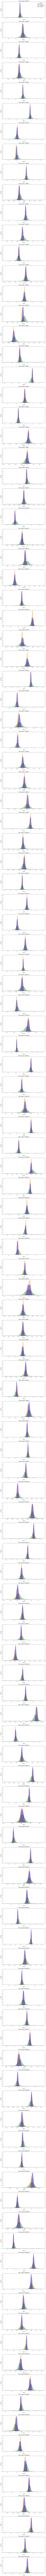

--- KDE Plots Generated ---
--- Evaluation Complete ---


In [18]:
# --- Main Execution ---

if __name__ == '__main__':
    # Define node count functions for different data types
    default_nodes_per_layer_fn = lambda k_idx: 2**k_idx
    swiss_roll_nodes_per_layer_fn = lambda k_idx: 1

    if EXPERIMENT_TYPE == 'tree':
        print("--- Running Experiment: Autoregressive Tree ---")
        CURRENT_FEATURE_DIM = TREE_FEATURE_DIM_CONFIG
        CURRENT_NUM_LAYERS = TREE_NUM_LAYERS_CONFIG
        current_feature_dim = TREE_FEATURE_DIM
        current_num_layers = TREE_NUM_LAYERS
        current_total_nodes_baseline = TREE_TOTAL_NODES # For baseline model on tree data
        nodes_per_layer_fn_for_baseline_unflatten = default_nodes_per_layer_fn
        nodes_per_layer_fn_for_seq_sampling = default_nodes_per_layer_fn

        dataset = TreeDataset(DATASET_SIZE, current_num_layers, TREE_ALPHA, TREE_NOISE_STD, current_feature_dim)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                                collate_fn=collate_tree_batch, num_workers=0,
                                pin_memory=True if DEVICE == torch.device("cuda") else False)

        # Sequential Model for Tree Data
        current_max_model_layers = TREE_NUM_LAYERS if EXPERIMENT_TYPE == 'tree' else SWISS_ROLL_SEQ_NUM_TREE_LAYERS

        seq_denoising_net = TreeDenoisingNetwork_Modified(
        feature_dim=CURRENT_FEATURE_DIM,      # Feature dim of the layer being denoised
        max_model_layers= current_max_model_layers,  # Max layers in this dataset type
        base_feature_dim=CURRENT_FEATURE_DIM, # Base feature dim for context concatenation
        time_emb_dim=128
        ).to(DEVICE)

        sequential_diffusion_model = SequentialTreeDiffusion_Modified(
        denoising_network=seq_denoising_net,
        max_model_layers=CURRENT_NUM_LAYERS, # Max layers for this dataset type
        base_feature_dim=CURRENT_FEATURE_DIM, # Base feature dim for nodes
        timesteps=TIMESTEPS,
        experiment_type=EXPERIMENT_TYPE # Pass experiment type
        ).to(DEVICE)

        # Baseline Model for Tree Data
        baseline_denoising_net = BaselineDenoisingNetwork(
            total_nodes=current_total_nodes_baseline, feature_dim=current_feature_dim, time_emb_dim=128
        ).to(DEVICE)
        baseline_diffusion_model = BaselineTreeDiffusion(
            denoising_network=baseline_denoising_net, total_nodes=current_total_nodes_baseline,
            feature_dim=current_feature_dim, timesteps=TIMESTEPS
        ).to(DEVICE)

        data_type_for_eval = 'tree'

    elif EXPERIMENT_TYPE == 'swiss_roll':
        print("--- Running Experiment: Thin Swiss-Roll (Sequential Format) ---")
        visualize_swiss_roll() # Show the 3D plot of the raw data

        current_feature_dim = SWISS_ROLL_SEQ_FEATURE_DIM
        current_num_layers = SWISS_ROLL_SEQ_NUM_TREE_LAYERS
        CURRENT_FEATURE_DIM = SWISS_ROLL_SEQ_FEATURE_DIM_CONFIG
        CURRENT_NUM_LAYERS = SWISS_ROLL_SEQ_NUM_TREE_LAYERS_CONFIG
        current_total_nodes_baseline = SWISS_ROLL_BASELINE_TOTAL_NODES # For baseline model on swiss roll (3 sequential nodes)
        nodes_per_layer_fn_for_baseline_unflatten = swiss_roll_nodes_per_layer_fn
        nodes_per_layer_fn_for_seq_sampling = swiss_roll_nodes_per_layer_fn

        dataset = SwissRollSequentialDataset(DATASET_SIZE)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                                collate_fn=collate_tree_batch, num_workers=0,
                                pin_memory=True if DEVICE == torch.device("cuda") else False)

        # Sequential Model for Swiss Roll Data
        seq_denoising_net_swiss = TreeDenoisingNetwork(
            feature_dim=current_feature_dim,
            context_feature_dim=current_feature_dim, # Parent's feature dim is also 1
            time_emb_dim=128
        ).to(DEVICE)
        """sequential_diffusion_model = SequentialTreeDiffusion(
            denoising_network=seq_denoising_net_swiss,
            num_layers=current_num_layers,
            feature_dim=current_feature_dim,
            timesteps=TIMESTEPS
        ).to(DEVICE)"""

        # Baseline Model for Swiss Roll Data (flattened sequential)
        baseline_denoising_net_swiss = BaselineDenoisingNetwork(
            total_nodes=current_total_nodes_baseline, # 3 nodes (X1, X2, X3)
            feature_dim=current_feature_dim, # 1 feature per node
            time_emb_dim=128
        ).to(DEVICE)
        baseline_diffusion_model = BaselineTreeDiffusion(
            denoising_network=baseline_denoising_net_swiss,
            total_nodes=current_total_nodes_baseline,
            feature_dim=current_feature_dim,
            timesteps=TIMESTEPS
        ).to(DEVICE)
        data_type_for_eval = 'swiss_roll'

    else:
        raise ValueError(f"Unknown EXPERIMENT_TYPE: {EXPERIMENT_TYPE}")

    # --- Train Models ---
    try:
        train_model(sequential_diffusion_model, dataloader, EPOCHS, LEARNING_RATE, DEVICE,
                    model_type='Sequential', current_total_nodes=0, # Not used by seq model train
                    current_feature_dim=current_feature_dim, current_num_layers=current_num_layers,
                    nodes_per_layer_fn_for_baseline=nodes_per_layer_fn_for_baseline_unflatten # Not used by seq model train
                   )
    except Exception as e:
        print(f"Error during Sequential model training: {e}")

    try:
        train_model(baseline_diffusion_model, dataloader, EPOCHS, LEARNING_RATE, DEVICE,
                    model_type='Baseline', current_total_nodes=current_total_nodes_baseline,
                    current_feature_dim=current_feature_dim, current_num_layers=current_num_layers,
                    nodes_per_layer_fn_for_baseline=nodes_per_layer_fn_for_baseline_unflatten
                   )
    except Exception as e:
        print(f"Error during Baseline model training: {e}")

    # --- Evaluate Models ---
    try:
        evaluate_models(sequential_diffusion_model, baseline_diffusion_model,
                       dataset.data, num_samples_to_generate=200, device=DEVICE,
                       current_num_layers=current_num_layers, data_type=data_type_for_eval,
                       nodes_per_layer_fn_for_unflatten=nodes_per_layer_fn_for_baseline_unflatten)
    except Exception as e:
        print(f"Error during model evaluation: {e}")